<a href="https://colab.research.google.com/github/Gobiilee/Research-and-build-model-ARIMA-VietNam-stock/blob/main/VietnamStiock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Đề tài: Vietnamese Banks Stocks



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import seaborn as sns
from tabulate import tabulate
from datetime import datetime
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

## I. Quan sát dữ liệu

In [ ]:
df = pd.read_csv("stock.csv")
df_without_pre_proccessing = df


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75709 entries, 0 to 75708
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   <Ticker>      75709 non-null  object 
 1   <DTYYYYMMDD>  75709 non-null  int64  
 2   <OpenFixed>   75709 non-null  float64
 3   <HighFixed>   75709 non-null  float64
 4   <LowFixed>    75709 non-null  float64
 5   <CloseFixed>  75709 non-null  float64
 6   <Volume>      75709 non-null  int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 4.0+ MB


### Lấy 5 điểm dữ liệu ra làm mẫu.


In [ ]:
df.head(5)

<Ticker>  <DTYYYYMMDD>  <OpenFixed>  <HighFixed>  <LowFixed>  <CloseFixed>  \
0      VCB      20170103        26.18        27.58       26.18         27.40   
1      VCB      20170104        27.58        27.66       27.07         27.21   
2      VCB      20170105        27.14        27.44       27.10         27.32   
3      VCB      20170106        27.36        28.24       27.29         27.88   
4      VCB      20170109        28.10        28.65       28.02         28.46   

   <Volume>  
0   2018750  
1   1339740  
2    855250  
3   2495910  
4   2379510

### Phân tích tỷ lệ duplicate

In [ ]:
num_duplicated_rows = df.duplicated().sum()
num_duplicated_rows

0

In [ ]:
len(df.drop_duplicates())/len(df)

1.0

In [ ]:
df.columns

Index(['<Ticker>', '<DTYYYYMMDD>', '<OpenFixed>', '<HighFixed>', '<LowFixed>',
       '<CloseFixed>', '<Volume>'],
      dtype='object')

### Phân tích tỷ lệ missing rate.

In [ ]:
percent_missing = df_without_pre_proccessing.isnull().sum() * 100 / len(df_without_pre_proccessing)
missing_value_df = pd.DataFrame({'column_name': df_without_pre_proccessing.columns,
                                 'percent_missing': percent_missing,
                                 'num_missing': df_without_pre_proccessing.isnull().sum()})
missing_value_df

column_name  percent_missing  num_missing
<Ticker>          <Ticker>              0.0            0
<DTYYYYMMDD>  <DTYYYYMMDD>              0.0            0
<OpenFixed>    <OpenFixed>              0.0            0
<HighFixed>    <HighFixed>              0.0            0
<LowFixed>      <LowFixed>              0.0            0
<CloseFixed>  <CloseFixed>              0.0            0
<Volume>          <Volume>              0.0            0

###  Fill missing rate.

In [ ]:
df = df.fillna(-1)

In [ ]:
df.isnull().sum() * 100 / len(df)

<Ticker>        0.0
<DTYYYYMMDD>    0.0
<OpenFixed>     0.0
<HighFixed>     0.0
<LowFixed>      0.0
<CloseFixed>    0.0
<Volume>        0.0
dtype: float64

#### Đổi tên thành tiếng việt

In [ ]:
rename_lst = ['<Mã>', '<Thời gian>', '<Giá mở>', '<Giá đỉnh>', '<Giá sàn>', '<Giá đóng>', '<Khối lượng>']
df.columns = rename_lst
df

<Mã>  <Thời gian>  <Giá mở>  <Giá đỉnh>  <Giá sàn>  <Giá đóng>  \
0      VCB     20170103     26.18       27.58      26.18       27.40   
1      VCB     20170104     27.58       27.66      27.07       27.21   
2      VCB     20170105     27.14       27.44      27.10       27.32   
3      VCB     20170106     27.36       28.24      27.29       27.88   
4      VCB     20170109     28.10       28.65      28.02       28.46   
...    ...          ...       ...         ...        ...         ...   
75704  VRE     20171115     36.75       37.27      34.73       35.29   
75705  VRE     20171114     39.29       39.29      36.75       37.27   
75706  VRE     20171113     36.75       36.75      36.75       36.75   
75707  VRE     20171110     34.37       34.37      34.37       34.37   
75708  VRE     20171106     32.15       32.15      32.15       32.15   

       <Khối lượng>  
0           2018750  
1           1339740  
2            855250  
3           2495910  
4           2379510  
...             ...  
75704       6550260  
75705      15464870  
75706        132380  
75707         31030  
75708           800  

[75709 rows x 7 columns]

### Nhận xét:
- Dữ liệu có 7 cột, trong đó:
    - Mã : Mã cổ phiếu của các ngân hàng
    - DTYYYYMMDD : Ngày được ghi nhận.
    - Giá mở : Giá mở là giá của một cổ phiếu, chứng khoán hoặc sản phẩm tài chính khác khi phiên giao dịch bắt đầu. Đây là giá đầu tiên được đưa ra trong ngày giao dịch
    - Giá đỉnh : Giá đỉnh là giá cao nhất mà một cổ phiếu, chứng khoán hoặc sản phẩm tài chính khác đạt được trong một phiên giao dịch.
    - Giá sàn : Giá sàn là giá thấp nhất mà một cổ phiếu, chứng khoán hoặc sản phẩm tài chính khác đạt được trong một phiên giao dịch.
    - Giá đóng : Giá đóng là giá của một cổ phiếu, chứng khoán hoặc sản phẩm tài chính khác khi phiên giao dịch kết thúc. Đây là giá cuối cùng được đưa ra trong ngày giao dịch.
    - Khối lượng : Khối lượng giao dịch là tổng số lượng cổ phiếu, chứng khoán hoặc sản phẩm tài chính khác được giao dịch trong một phiên giao dịch. Đây là một chỉ số quan trọng để đo lường sự sôi động của thị trường và khối lượng lớn nhỏ của giao dịch có thể ảnh hưởng đến giá của một sản phẩm tài chính.


In [ ]:
print("Số lượng dòng:", df.shape[0])
print("Số lượng cột:", df.shape[1])
print("Số lượng cổ phiếu:", df['<Mã>'].nunique())
print("Số ngày lấy dữ liệu:", df['<Thời gian>'].nunique())

Số lượng dòng: 75709
Số lượng cột: 7
Số lượng cổ phiếu: 32
Số ngày lấy dữ liệu: 5514


In [ ]:
df['<Mã>'].unique()


array(['VCB', 'ACB', 'MBB', 'FPT', 'MSN', 'SAB', 'HPG', 'GAS', 'BID',
       'TCB', 'BVH', 'CTG', 'HDB', 'KDH', 'MWG', 'NVL', 'PDR', 'PLX',
       'PNJ', 'POW', 'REE', 'SBT', 'SSI', 'STB', 'TCH', 'TPB', 'VHM',
       'VIC', 'VJC', 'VNM', 'VPB', 'VRE'], dtype=object)

### 32 mã cổ phiếu chứng khoán khác nhau bao gồm:
- **VCB**: Ngân hàng thương mại cổ phần Ngoại thương Việt Nam
- **ACB**: Ngân hàng thương mại cổ phần Á Châu
- **MBB**: Ngân hàng TMCP Quân Đội
- **FPT**: Tập đoàn FPT
- **MSN**: CTCP Tập đoàn Masan
- **SAB**: Tổng Công ty cổ phần Bia - Rượu - Nước giải khát Sài Gòn
- **HPG**: Tập đoàn Hòa Phát
- **GAS**: Tổng Công ty Khí Việt Nam - CTCP
- **BID**: Ngân hàng TMCP Đầu tư và Phát triển Việt Nam
- **TCB**: Ngân hàng Thương mại cổ phần Kỹ Thương Việt Nam
- **BVH**: Bảo hiểm nhân thọ Prudential Việt Nam
- **CTG**: Ngân hàng Thương mại Cổ phần Công Thương Việt Nam
- **HDB**: Ngân hàng Thương mại Cổ phần Phát triển Thành phố Hồ Chí Minh
- **KDH**: Công ty Cổ phần Đầu tư và Phát triển Nhà Khang Điền
- **MWG**: Tổng Công ty CP Đầu tư Thế giới di động
- **NVL**: Tập đoàn Đầu tư và Phát triển Bất động sản Novaland
- **PDR**: Công ty Cổ phần Phát triển Bất động sản Phát Đạt
- **PLX**: Tập đoàn Dầu khí Việt Nam
- **PNJ**: Công ty Cổ phần Vàng bạc Đá quý Phú Nhuận
- **POW**: Công ty Cổ phần Điện lực Dầu khí
- **REE**: Công ty Cổ phần Cơ điện lạnh
- **SBT**: Công ty Cổ phần Thức ăn chăn nuôi Sao Ta
- **SSI**: Công ty Cổ phần Chứng khoán Sài Gòn
- **STB**: Ngân hàng TMCP Sài Gòn Thương Tín
- **TCH**: Công ty Cổ phần Chứng khoán Techcombank
- **TPB**: Ngân hàng Thương mại Cổ phần Tiên Phong
- **VHM**: Tập đoàn Vingroup - Công ty Cổ phần Tập đoàn Vinhomes
- **VIC**: Tập đoàn Vingroup - Công ty Cổ phần Tập đoàn Vincommerce
- **VJC**: Công ty Cổ phần Hàng không VietJet
- **VNM**: Công ty Cổ phần Sữa Việt Nam
- **VPB**: Ngân hàng Thương mại Cổ phần Việt Nam Thịnh Vượng
- **VRE**: Công ty Cổ phần Vincom Retail

### Xóa cột thời gian để thực hiện thống kê mô tả

In [ ]:

df_process = df.drop('<Thời gian>', axis=1)

# II. Thực hiện trực quan

## Thống kê toàn bộ dữ liệu

In [ ]:
statistics = df_process.describe()

# Tính Variance và Median
variance = df_process.var(numeric_only=True)  # Tính Variance cho mỗi cột
median = df_process.median(numeric_only=True)  # Tính Median cho mỗi cột

# Thêm cột "Variance" và "Median" vào statistics
statistics.loc['Variance'] = variance
statistics.loc['Median'] = median
statistics

<Giá mở>    <Giá đỉnh>     <Giá sàn>    <Giá đóng>  <Khối lượng>
count     75709.000000  75709.000000  75709.000000  75709.000000  7.570900e+04
mean         34.078269     34.516384     33.648068     34.086296  1.848631e+06
std          37.202397     37.646794     36.725780     37.201476  4.129037e+06
min           0.000000      0.860000      0.010000      0.860000  0.000000e+00
25%          10.780000     10.910000     10.650000     10.770000  2.039300e+05
50%          19.770000     20.020000     19.500000     19.780000  6.293100e+05
75%          43.730000     44.320000     43.280000     43.750000  1.701190e+06
max         305.390000    310.040000    294.850000    302.890000  9.997850e+07
Variance   1384.018364   1417.281094   1348.782946   1383.949794  1.704894e+13
Median       19.770000     20.020000     19.500000     19.780000  6.293100e+05

### Nhận xét:
- Giá đóng trung bình của cổ phiếu là 34.086296 VNĐ.
- Khối lượng giao dịch trung bình mỗi ngày là 1,848,631.
- Phân tích thống kê cho thấy variance của dữ liệu cho từng cột rất cao, cho thấy dữ liệu phân tán rộng và không gần giá trị trung bình.
- Giá mở của cổ phiếu dao động từ 0 đến 305.39, với giá trung vị là 19.77.
- Giá đỉnh của cổ phiếu dao động từ 0.86 đến 310.04, với giá trung vị là 20.02.
- Giá sàn của cổ phiếu dao động từ 0.01 đến 294.85, với giá trung vị là 19.50.
- Giá đóng của cổ phiếu dao động từ 0.86 đến 302.89, với giá trung vị là 19.78.
- Khối lượng giao dịch dao động từ 0 đến 99,978,500, với giá trung vị là 629,310.

## Theo mã cổ phiếu

In [ ]:
tickers = ['VCB', 'ACB', 'MBB', 'FPT', 'MSN', 'SAB', 'HPG', 'GAS', 'BID', \
       'TCB', 'BVH', 'CTG', 'HDB', 'KDH', 'MWG', 'NVL', 'PDR', 'PLX',  \
       'PNJ', 'POW', 'REE', 'SBT', 'SSI', 'STB', 'TCH', 'TPB', 'VHM', \
       'VIC', 'VJC', 'VNM', 'VPB', 'VRE']

In [ ]:
for i in tickers:
    print(i,'\n')
    df_subset = df_process[df_process['<Mã>'] == i]
    statistic = df_subset.describe()

    variance = df_subset.var(numeric_only=True)
    median = df_subset.median(numeric_only=True)

    statistic.loc['Variance'] = variance
    statistic.loc['Median'] = median

    print(statistic,'\n')


VCB 

             <Giá mở>   <Giá đỉnh>    <Giá sàn>   <Giá đóng>  <Khối lượng>
count     3447.000000  3447.000000  3447.000000  3447.000000  3.447000e+03
mean        38.056403    38.534775    37.596391    38.073647  9.511352e+05
std         24.457486    24.751643    24.138698    24.467563  8.048219e+05
min         10.100000    10.300000    10.100000    10.100000  1.895000e+04
25%         16.180000    16.400000    16.030000    16.200000  3.900050e+05
50%         29.110000    29.520000    28.830000    29.110000  7.451000e+05
75%         59.900000    60.740000    59.400000    60.170000  1.248050e+06
max         95.800000    96.300000    94.000000    96.000000  7.265480e+06
Variance   598.168634   612.643850   582.676756   598.661622  6.477384e+11
Median      29.110000    29.520000    28.830000    29.110000  7.451000e+05 

ACB 

             <Giá mở>   <Giá đỉnh>    <Giá sàn>   <Giá đóng>  <Khối lượng>
count     1575.000000  1575.000000  1575.000000  1575.000000  1.575000e+03
mean       

### Nhận xét:
- Nhìn chung giá đóng trung bình của cổ phiếu SAB là cao nhất so với các cổ phiếu còn lại
- Tuy nhiên về độ lệch về giá và Khối lượng của một số cổ phiếu là khá cao như VCB, ACB

## Tần suất các thuộc tính phụ thuộc của các mã chứng khoán

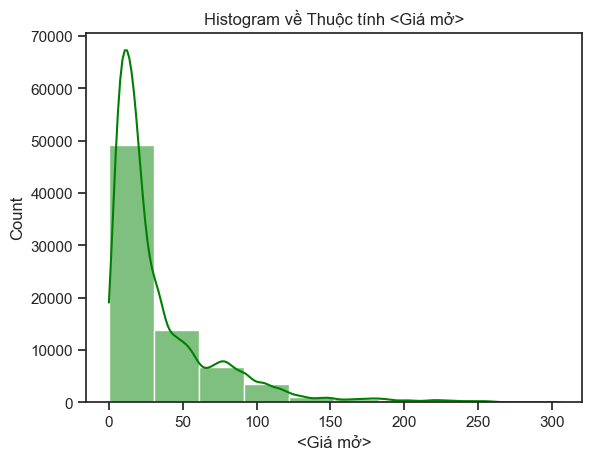

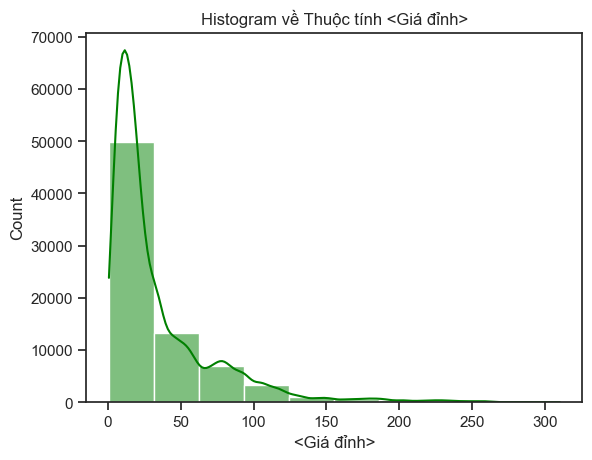

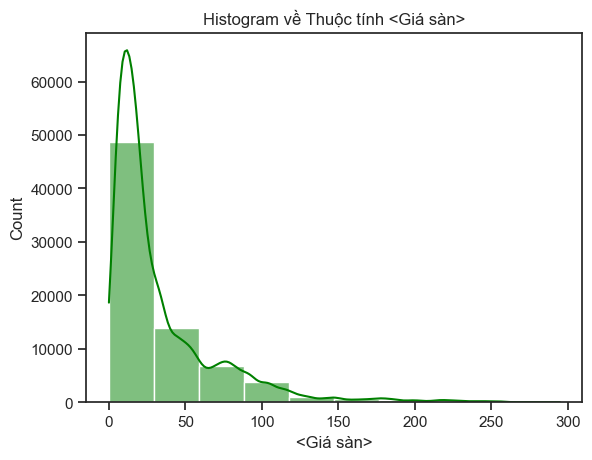

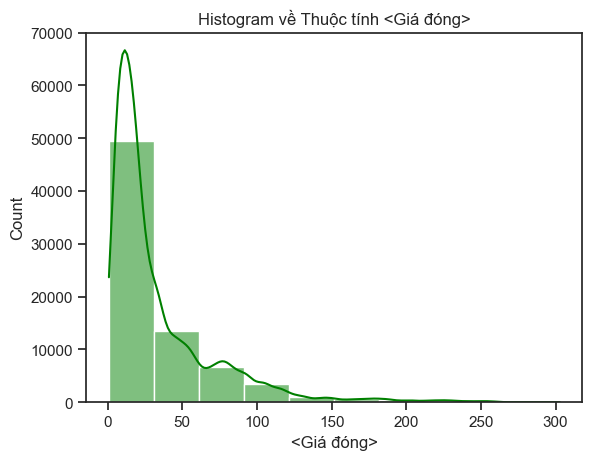

In [ ]:
names = df_process.columns
for col in names[1:-1]:
    sns.histplot(data=df_process, x=col, bins=10, kde=True, color='#008000', fill=True)
    plt.title("Histogram về Thuộc tính " + col)
    plt.show()

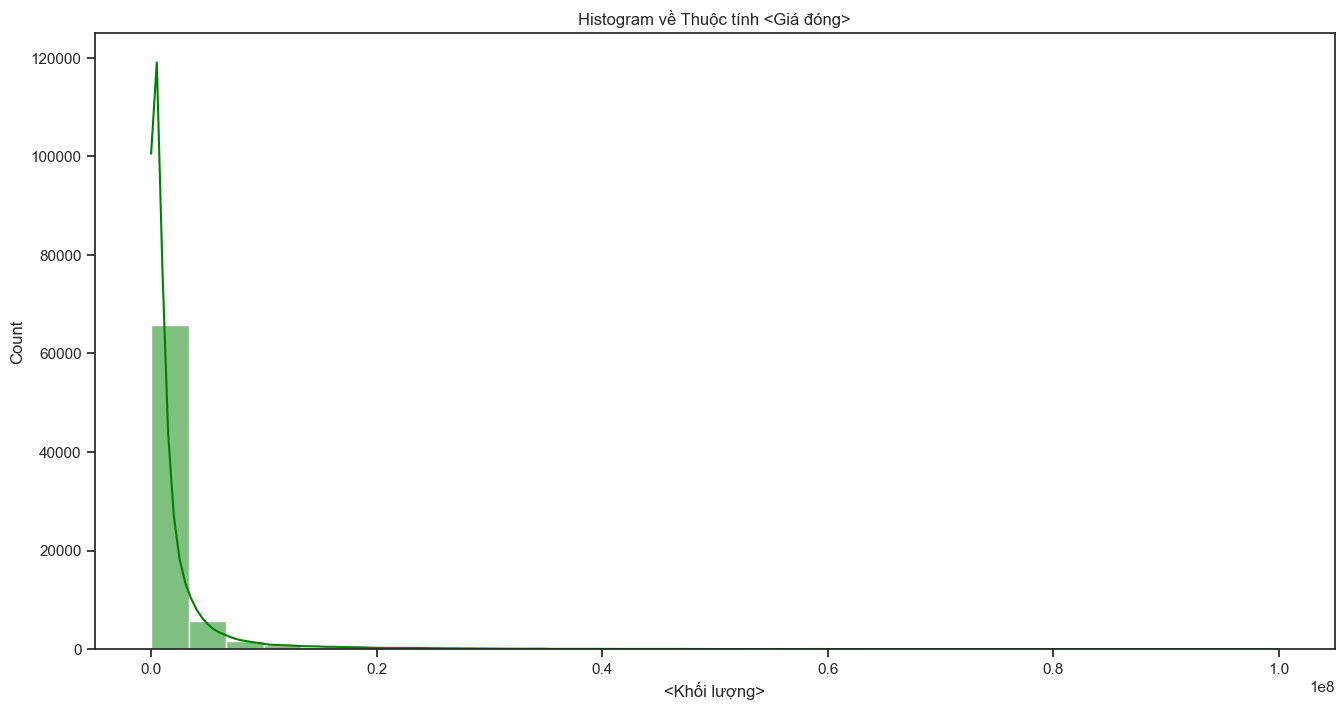

In [ ]:
plt.figure(figsize=(16,8))
sns.histplot(data=df_process, x='<Khối lượng>', bins=30, kde=True, color='#008000', fill=True)
plt.title("Histogram về Thuộc tính " + col)
plt.show()

#### Nhận xét:
- Độ lệch dương (positive skewness): Điều này ngụ ý rằng phân phối của các biến giá có xu hướng kéo dài về phía bên phải, có nghĩa là có một số quan sát có giá trị cao hơn so với giá trung bình hoặc giá trung vị. Trong ngữ cảnh của giá cổ phiếu, điều này có thể chỉ ra sự xuất hiện của một số cổ phiếu có giá cao hơn rất nhiều so với phần lớn các cổ phiếu khác.

- Độ nhọn dương: Điều này ngụ ý rằng phân phối của các biến giá có đỉnh cao và hẹp hơn so với phân phối chuẩn. Trong ngữ cảnh của giá cổ phiếu, điều này có thể cho thấy có một số cổ phiếu tập trung ở một phạm vi giá cụ thể, không có sự phân tán lớn.

- Những đặc điểm này có thể phản ánh các biến động đặc biệt trong thị trường cổ phiếu, có thể là do sự tập trung của một số cổ phiếu lớn hoặc sự biến động mạnh mẽ trong một số cổ phiếu nhất định. Điều này cũng có thể phản ánh các yếu tố khác như sự phụ thuộc vào lĩnh vực công nghệ hoặc tài chính, hoặc các yếu tố khác như sự kiểm soát của một số nhà đầu tư lớn.








## Thực hiện tương quan dữ liệu bằng Heatmap

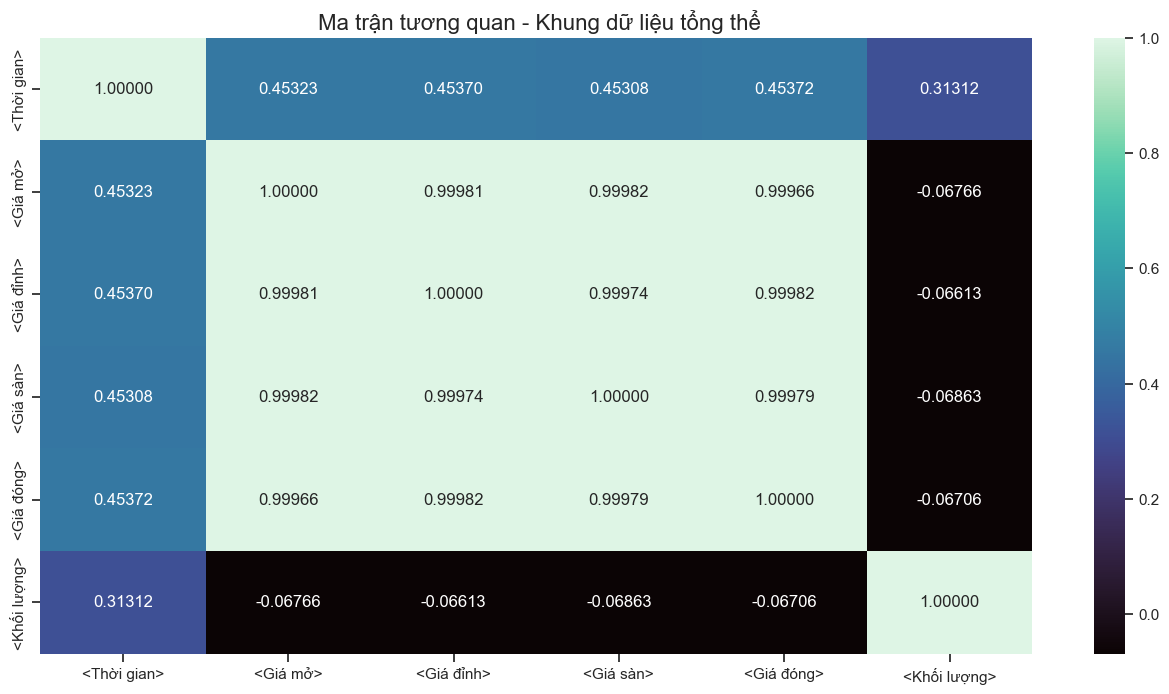

In [ ]:
# Correlation heatmap for the overall DataFrame
plt.figure(figsize=(16,8))
corr = df.corr()
sns.heatmap(corr, annot=True, fmt=".5f", cmap='mako')
plt.title(' Ma trận tương quan - Khung dữ liệu tổng thể', size=16)
plt.show()

#### Nhận xét:
- Phân tích biểu đồ cho thấy sự tương quan dương mạnh mẽ giữa giá mở, giá đỉnh, giá sàn và giá đóng của các cổ phiếu.
- Mặt khác, khối lượng giao dịch thường không có mối tương quan lớn với các loại giá, cho thấy rằng sự biến động trong giá cổ phiếu có thể không phụ thuộc nhiều vào khối lượng giao dịch.

In [ ]:
vcb_df = df.loc[df['<Mã>'] == 'VCB']
acb_df = df.loc[df['<Mã>'] == 'ACB']
bid_df = df.loc[df['<Mã>'] == 'BID']
fpt_df = df.loc[df['<Mã>'] == 'FPT']
gas_df = df.loc[df['<Mã>'] == 'GAS']
hpg_df = df.loc[df['<Mã>'] == 'HPG']
mbb_df = df.loc[df['<Mã>'] == 'MBB']
msn_df = df.loc[df['<Mã>'] == 'MSN']
sab_df = df.loc[df['<Mã>'] == 'SAB']
tcb_df = df.loc[df['<Mã>'] == 'TCB']
bvh_df = df.loc[df['<Mã>'] == 'BVH']
ctg_df = df.loc[df['<Mã>'] == 'CTG']
hdb_df = df.loc[df['<Mã>'] == 'HDB']
kdh_df = df.loc[df['<Mã>'] == 'KDH']
mwg_df = df.loc[df['<Mã>'] == 'MWG']
nvl_df = df.loc[df['<Mã>'] == 'NVL']
pdr_df = df.loc[df['<Mã>'] == 'PDR']
plx_df = df.loc[df['<Mã>'] == 'PLX']
pnj_df = df.loc[df['<Mã>'] == 'PNJ']
pow_df = df.loc[df['<Mã>'] == 'POW']
ree_df = df.loc[df['<Mã>'] == 'REE']
sbt_df = df.loc[df['<Mã>'] == 'SBT']
ssi_df = df.loc[df['<Mã>'] == 'SSI']
stb_df = df.loc[df['<Mã>'] == 'STB']
tch_df = df.loc[df['<Mã>'] == 'TCH']
tpb_df = df.loc[df['<Mã>'] == 'TPB']
vhm_df = df.loc[df['<Mã>'] == 'VHM']
vic_df = df.loc[df['<Mã>'] == 'VIC']
vjc_df = df.loc[df['<Mã>'] == 'VJC']
vnm_df = df.loc[df['<Mã>'] == 'VNM']
vpb_df = df.loc[df['<Mã>'] == 'VPB']
vre_df = df.loc[df['<Mã>'] == 'VRE']


In [ ]:
# corr_df = [vcb_df, acb_df, mbb_df, fpt_df, msn_df, sab_df, hpg_df, gas_df, bid_df,
#        tcb_df, bvh_df, ctg_df, hdb_df, kdh_df, mwg_df, nvl_df, pdr_df, plx_df,
#        pnj_df, pow_df, ree_df, sbt_df, ssi_df, stb_df, tch_df, tpb_df, vhm_df,
#        vic_df, vjc_df, vnm_df, vpb_df, vre_df]

corr_df = [acb_df, sab_df, tcb_df, stb_df, ctg_df, ssi_df, mwg_df, nvl_df, pnj_df, sbt_df]

tickers_base = ['ACB', 'SAB', 'TCB', \
           'STB', 'CTG', 'SSI', 'MWG', 'NVL', "PNJ", "SBT" ]

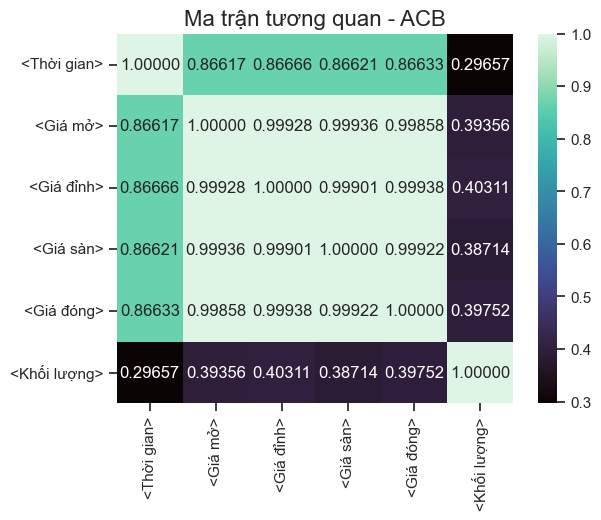

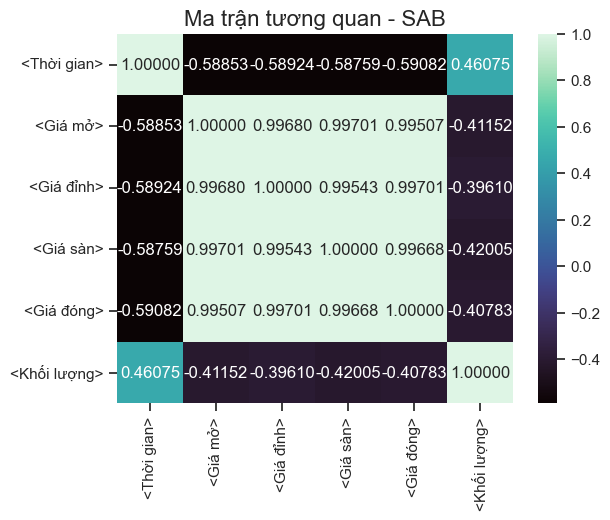

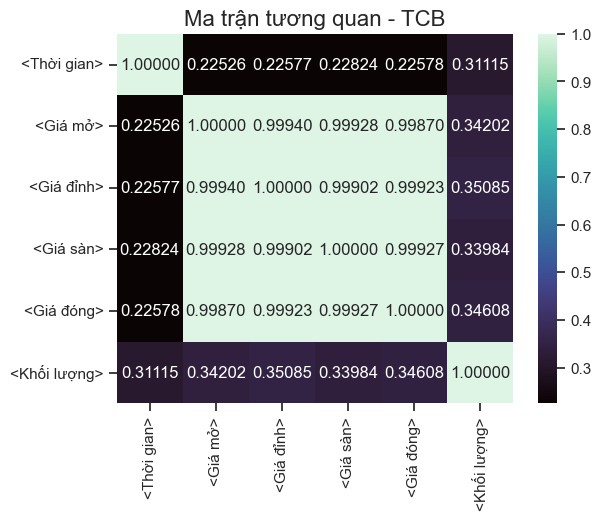

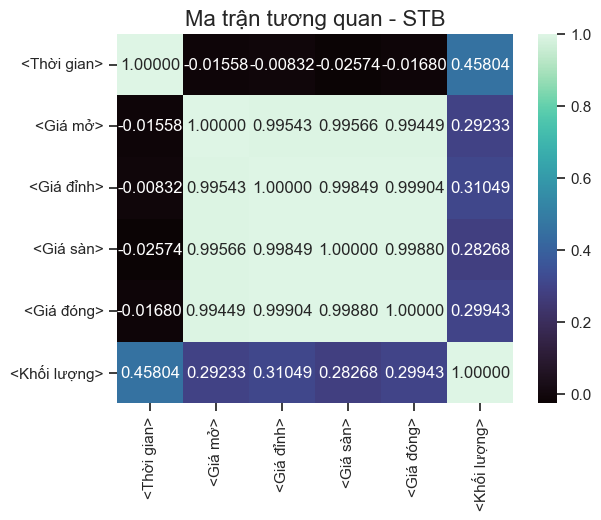

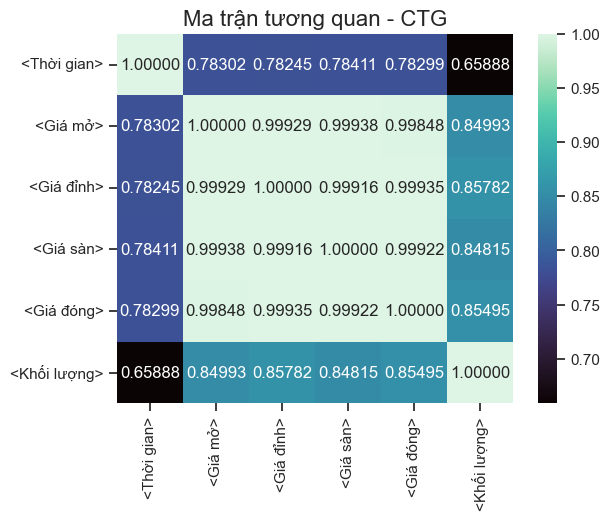

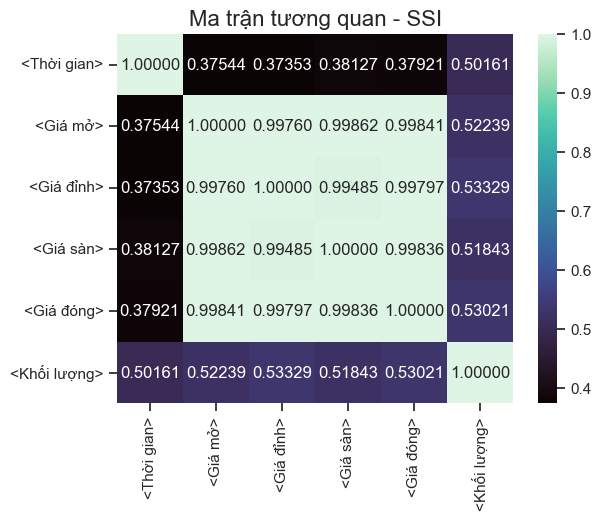

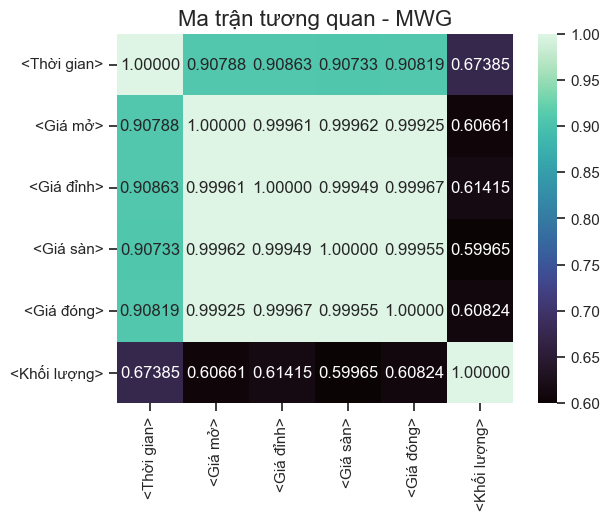

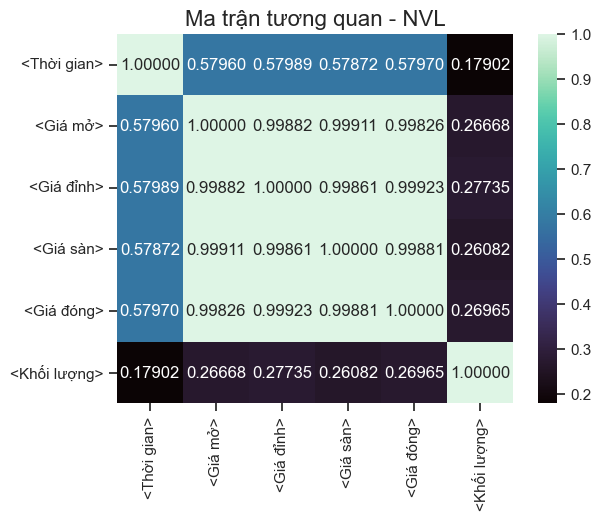

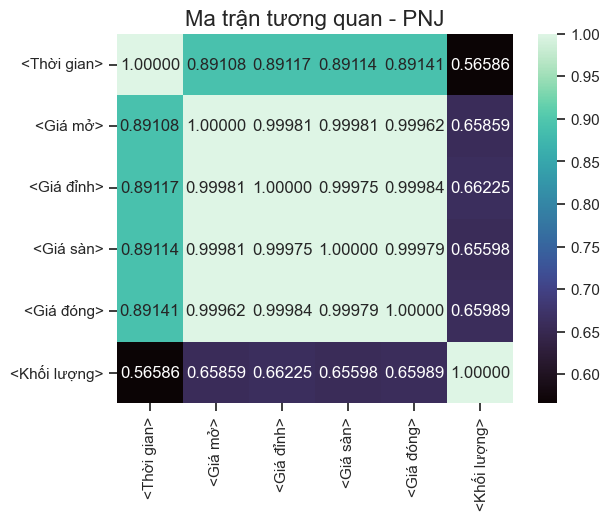

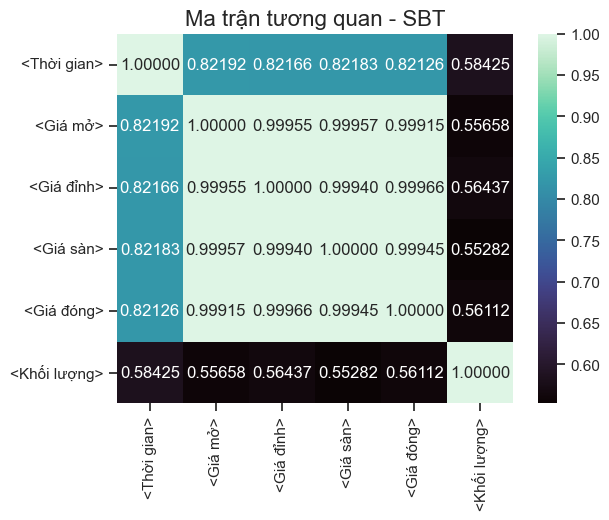

In [ ]:
for df_process, Mã in zip(corr_df, tickers_base):
    corr = df_process.corr()
    sns.heatmap(corr, annot=True, fmt=".5f", cmap='mako')
    plt.title(f'Ma trận tương quan - {Mã}', size=16)
    plt.show()

### Nhận xét:
- Mặc dù có sự tương quan cao giữa ngày và các loại giá đối với một số cổ phiếu, nhưng không phải tất cả các loại cổ phiếu đều thể hiện mối quan hệ này. Điều này có thể chỉ ra sự đa dạng trong biểu đồ giá của các cổ phiếu, có thể phản ánh sự biến động khác nhau trên thị trường.
- Biểu đồ đã tạo ra một cách trực quan để thể hiện sự tương quan giữa các dữ liệu. Sự sắp xếp các loại giá theo thời gian giúp chúng ta dễ dàng so sánh và nhận biết xu hướng chung của dữ liệu. Các điểm ngoại lệ cũng được nêu bật, giúp chúng ta nhận ra những biến động đáng chú ý trong tập dữ liệu. Điều này giúp tạo ra một cái nhìn tổng quan và sinh động về cách mà các loại giá của cổ phiếu biến động theo thời gian.

## Trực quan phân bố dữ liệu mã chứng khoán bằng Boxplot

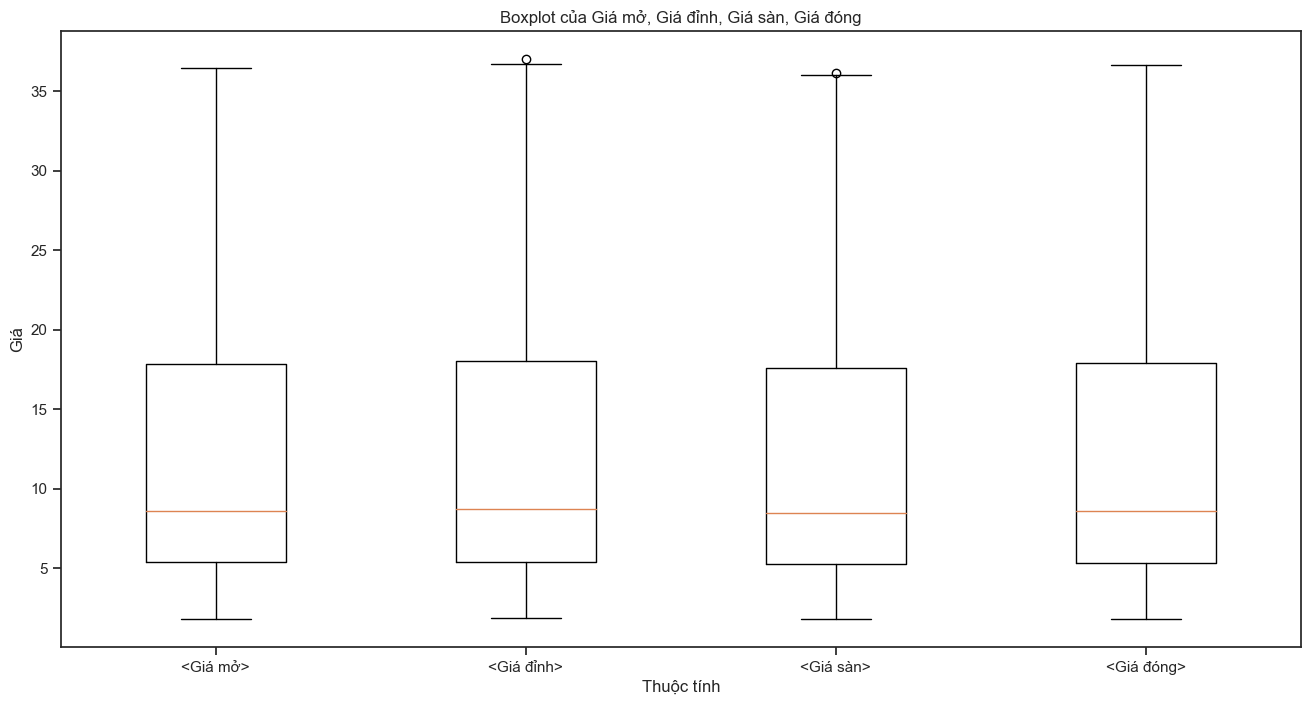

In [ ]:
plt.figure(figsize=(16,8))
column = ['<Giá mở>', '<Giá đỉnh>', '<Giá sàn>', '<Giá đóng>']
plt.boxplot(df_process[column])
plt.xticks([1, 2, 3, 4], column)
plt.ylabel('Giá')
plt.xlabel('Thuộc tính')
plt.title('Boxplot của Giá mở, Giá đỉnh, Giá sàn, Giá đóng')
plt.show()

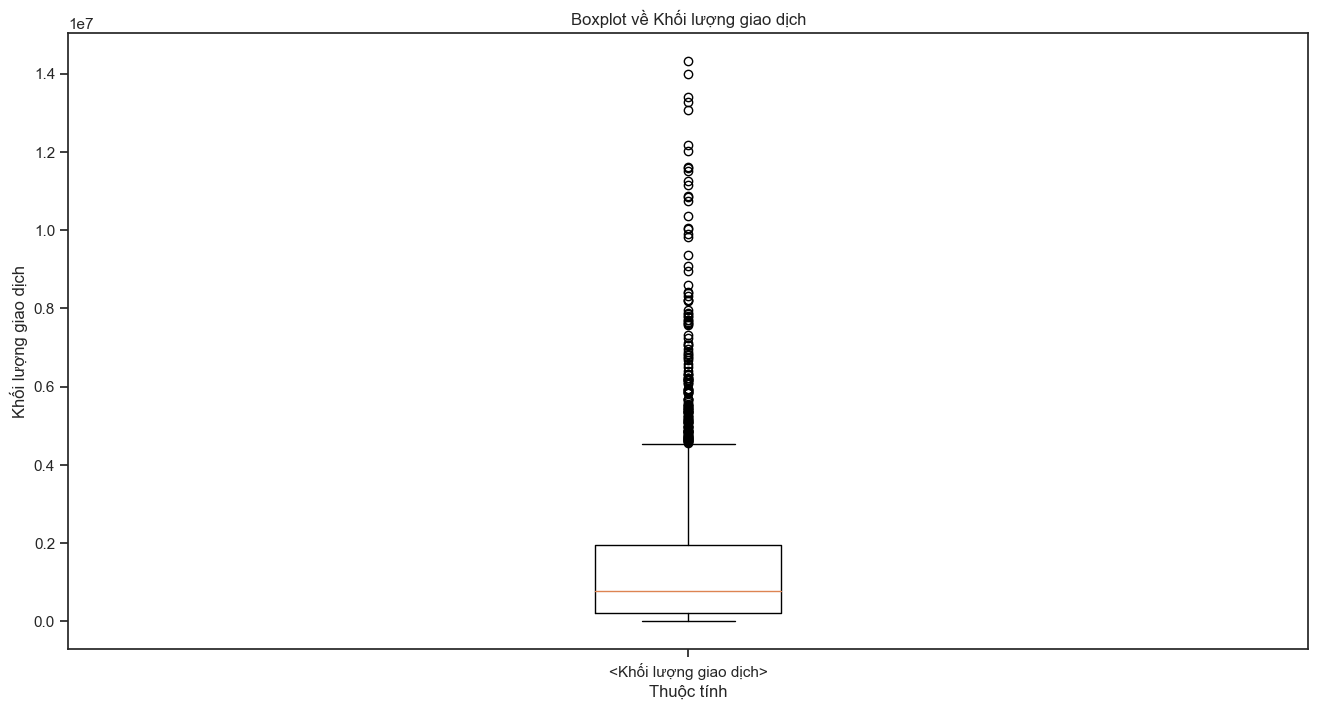

In [ ]:
plt.figure(figsize=(16,8))
plt.boxplot(df_process['<Khối lượng>'])
plt.xticks([1],['<Khối lượng giao dịch>'])
plt.ylabel('Khối lượng giao dịch')
plt.xlabel('Thuộc tính')
plt.title('Boxplot về Khối lượng giao dịch')
plt.show()

#### Đánh giá:
- Các mức giá như giá mở cửa, cao nhất, thấp nhất và đóng cửa của cổ phiếu thường tập trung ở khoảng từ 25 đến 100 ngàn đồng.
- Tuy nhiên, xuất hiện nhiều điểm ngoại lệ với giá cao hơn, từ 150 đến hơn 300 ngàn đồng, cho thấy sự biến động lớn ở các mức giá này.
- Sự chênh lệch giữa các giá trị trung bình của các loại giá không đáng kể, tức là giữa giá mở cửa, giá đóng cửa và giá cao - thấp trong ngày thường không có sự biến động lớn.
- Mô hình dữ liệu cho thấy phân phối của các biến giá có tính chất là độ lệch dương và độ nhọn dương, với đỉnh ở khoảng 25-100 ngàn đồng, nhưng cũng có sự biến động lớn ở mức giá cao hơn.
#### Đánh giá khối lượng giao dịch
- Dường như có sự chia rẽ rõ rệt giữa các ngày giao dịch, với phần lớn các phiên giao dịch có khối lượng dưới 10,000,000 lượt. Tuy nhiên, các điểm ngoại lệ đáng chú ý với số lượng giao dịch khổng lồ, thậm chí có thể lên đến 100,000,000 lượt, tạo ra một biến động lớn đối với trung bình.
- Phân phối khối lượng giao dịch thể hiện sự đa dạng, với khoảng từ 100,000 đến 10,000,000 lượt giao dịch là phổ biến nhất, nhưng vẫn có sự xuất hiện của các giá trị ngoại lệ, đặc biệt là ở các mức giao dịch cao.

### Trực quan dữ liệu của các cột theo từng mã cổ phiếu

#### Khối lượng

In [ ]:
filtered_df = df_process[df_process['<Mã>'].isin(tickers)]

In [ ]:
def plot_boxplot(filtered_df, column_name, by_column, figsize=(16, 10)):
    filtered_df.boxplot(column=column_name, by=by_column, figsize=figsize)
    plt.title(f'Boxplot về {column_name} cho mỗi {by_column}')
    plt.xlabel(by_column)
    plt.ylabel(column_name)
    plt.show()

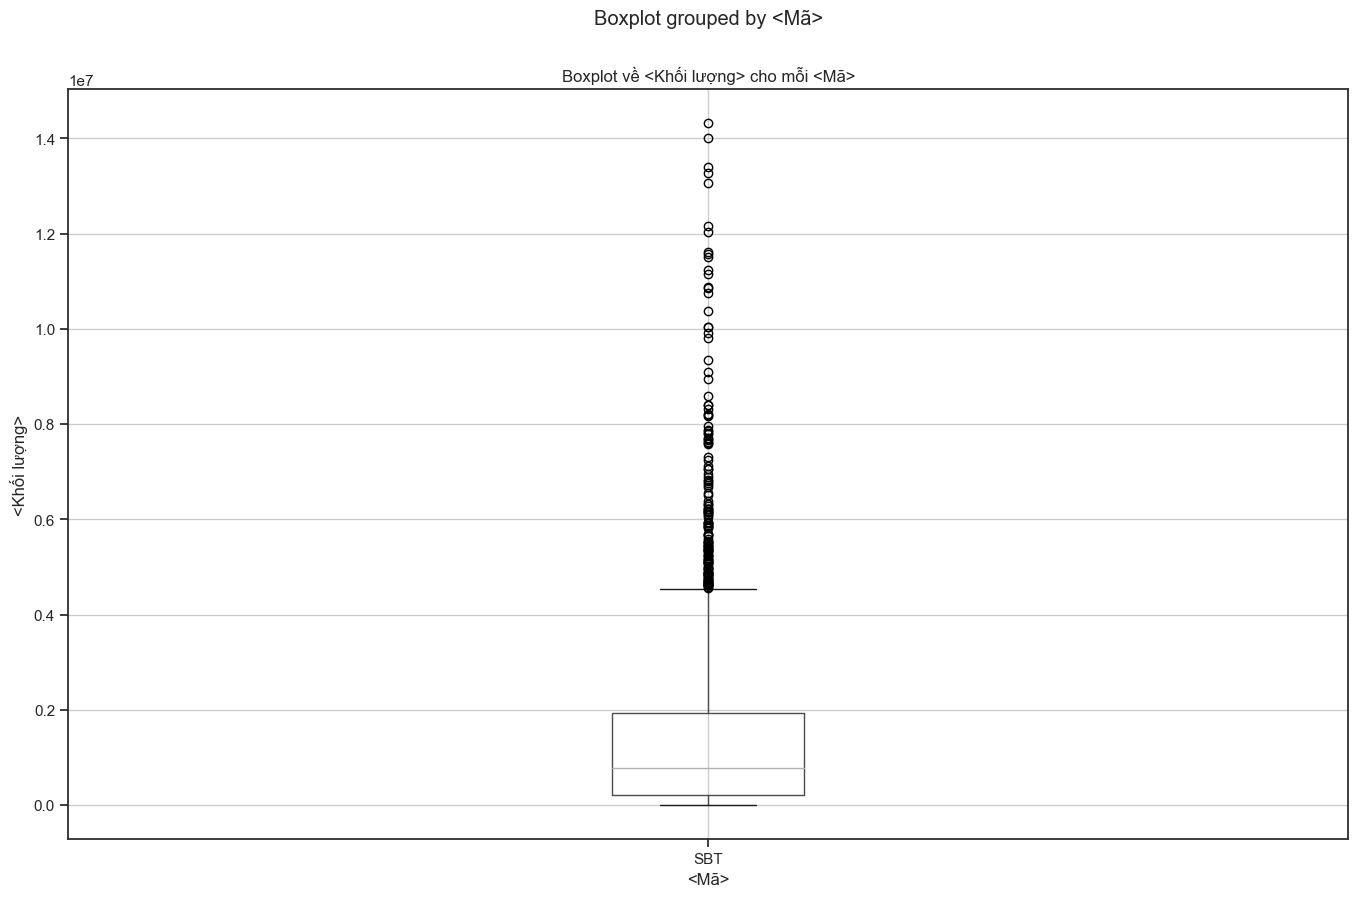

In [ ]:
plot_boxplot(filtered_df, column_name='<Khối lượng>', by_column='<Mã>')


#### Nhận xét:
- Phân tích dữ liệu cho thấy sự tương đồng giữa HPG và TCB về khối lượng giao dịch, hai cổ phiếu này có xu hướng có lượng giao dịch đáng kể hơn so với các cổ phiếu khác trong danh sách.
- Đặc biệt, cổ phiếu TCB nổi bật với mức khối lượng giao dịch cao nhất, cho thấy sự quan tâm đặc biệt từ phía thị trường và các nhà đầu tư đối với cổ phiếu này.

#### Giá mở

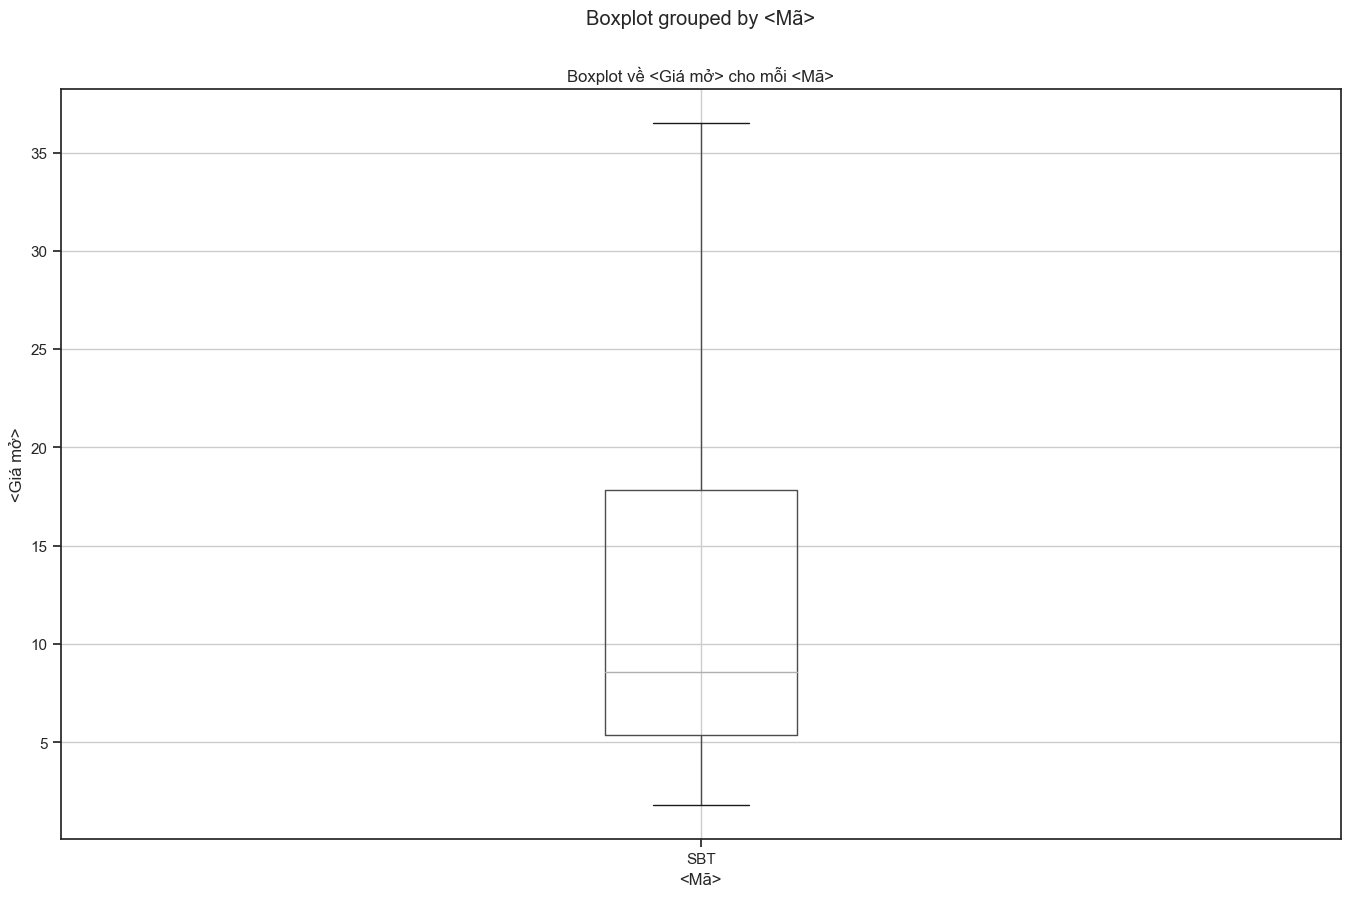

In [ ]:
plot_boxplot(filtered_df, column_name='<Giá mở>', by_column='<Mã>')

#### Nhận xét
- Dữ liệu cho thấy giá mở của SAB nổi bật với mức độ cao hơn đáng kể so với các mã chứng khoán khác trong danh sách.
- Mặt khác, cổ phiếu POW lại có xu hướng có giá mở thấp nhất, tạo ra sự đối lập rõ ràng với SAB. Điều này có thể phản ánh sự khác biệt trong sự quan tâm của thị trường và các nhà đầu tư đối với hai cổ phiếu này.

#### Giá đỉnh

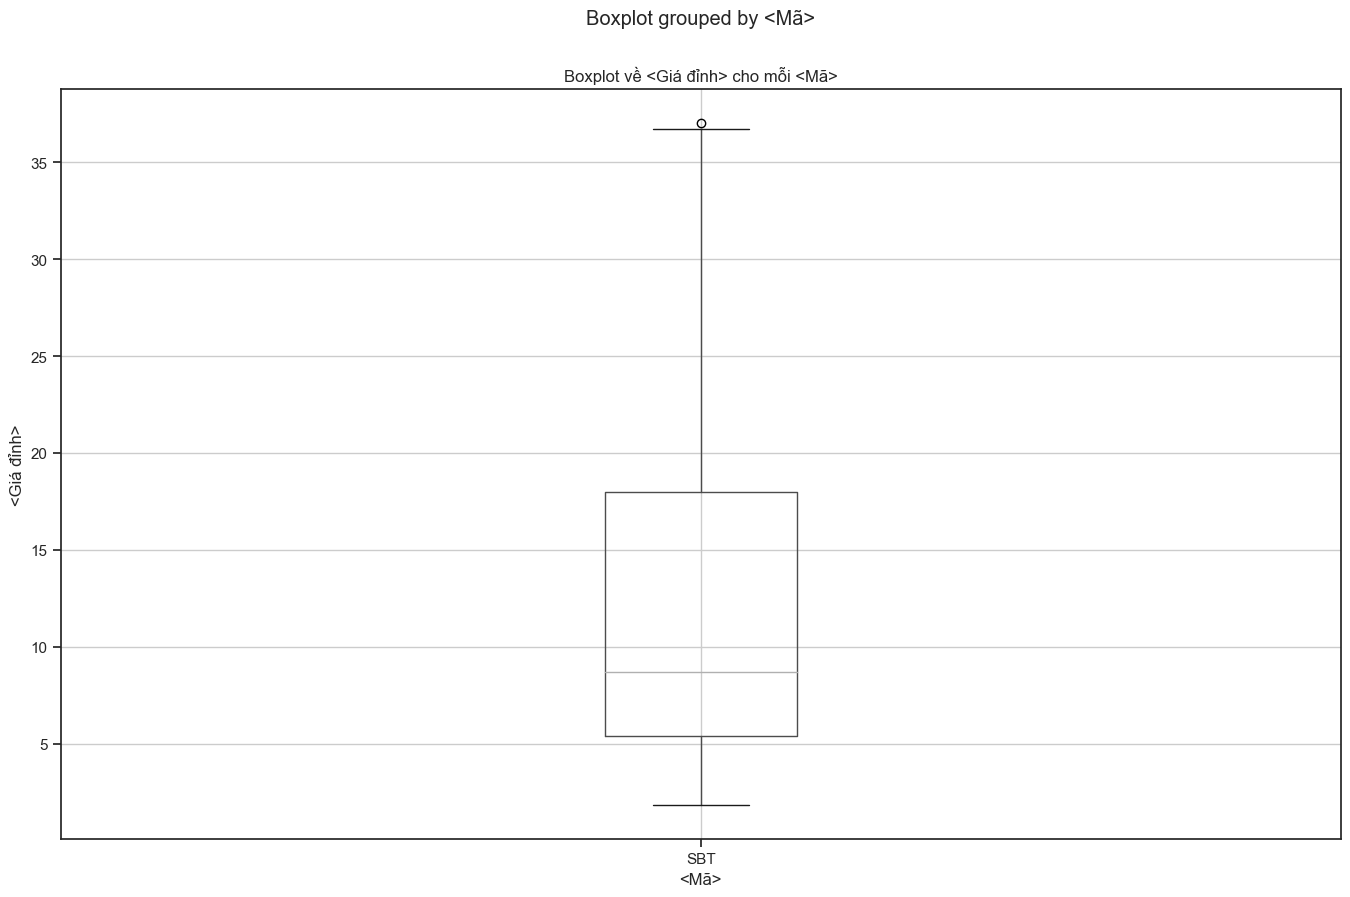

In [ ]:
plot_boxplot(filtered_df, column_name='<Giá đỉnh>', by_column='<Mã>')

#### Nhận xét
- SAB nổi bật với giá đỉnh cao hơn hoàn toàn so với các mã chứng khoán khác trong tập dữ liệu.
- Trong khi đó, POW lại xuất hiện với mức giá đỉnh thấp nhất, tạo ra một sự tương phản rõ ràng giữa hai mã này. Điều này có thể chỉ ra sự chênh lệch trong sự quan tâm và hoạt động giao dịch của thị trường đối với hai mã cổ phiếu này.

#### Giá sàn

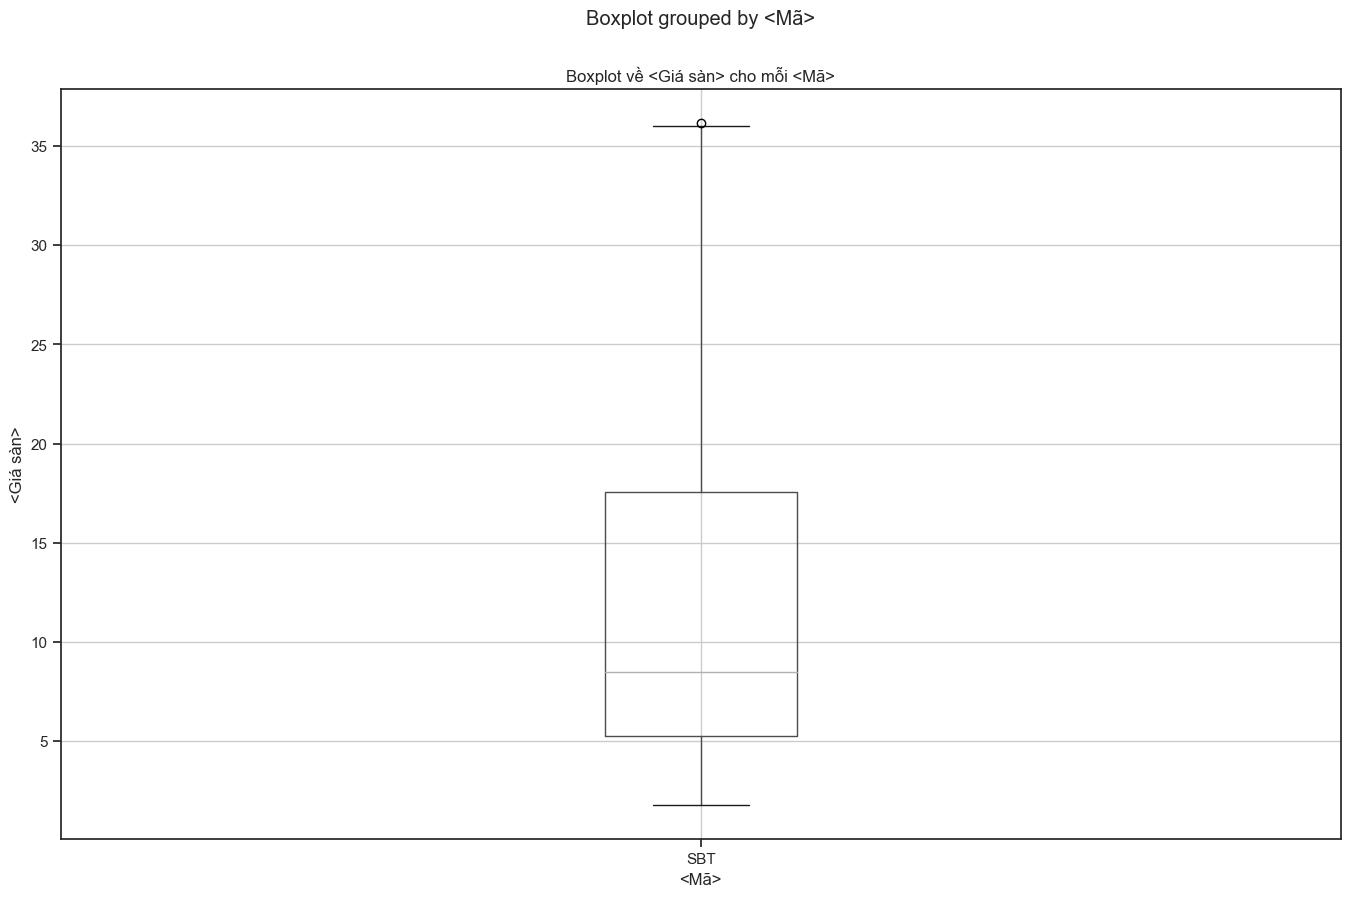

In [ ]:
plot_boxplot(filtered_df, column_name='<Giá sàn>', by_column='<Mã>')

#### Giá đóng

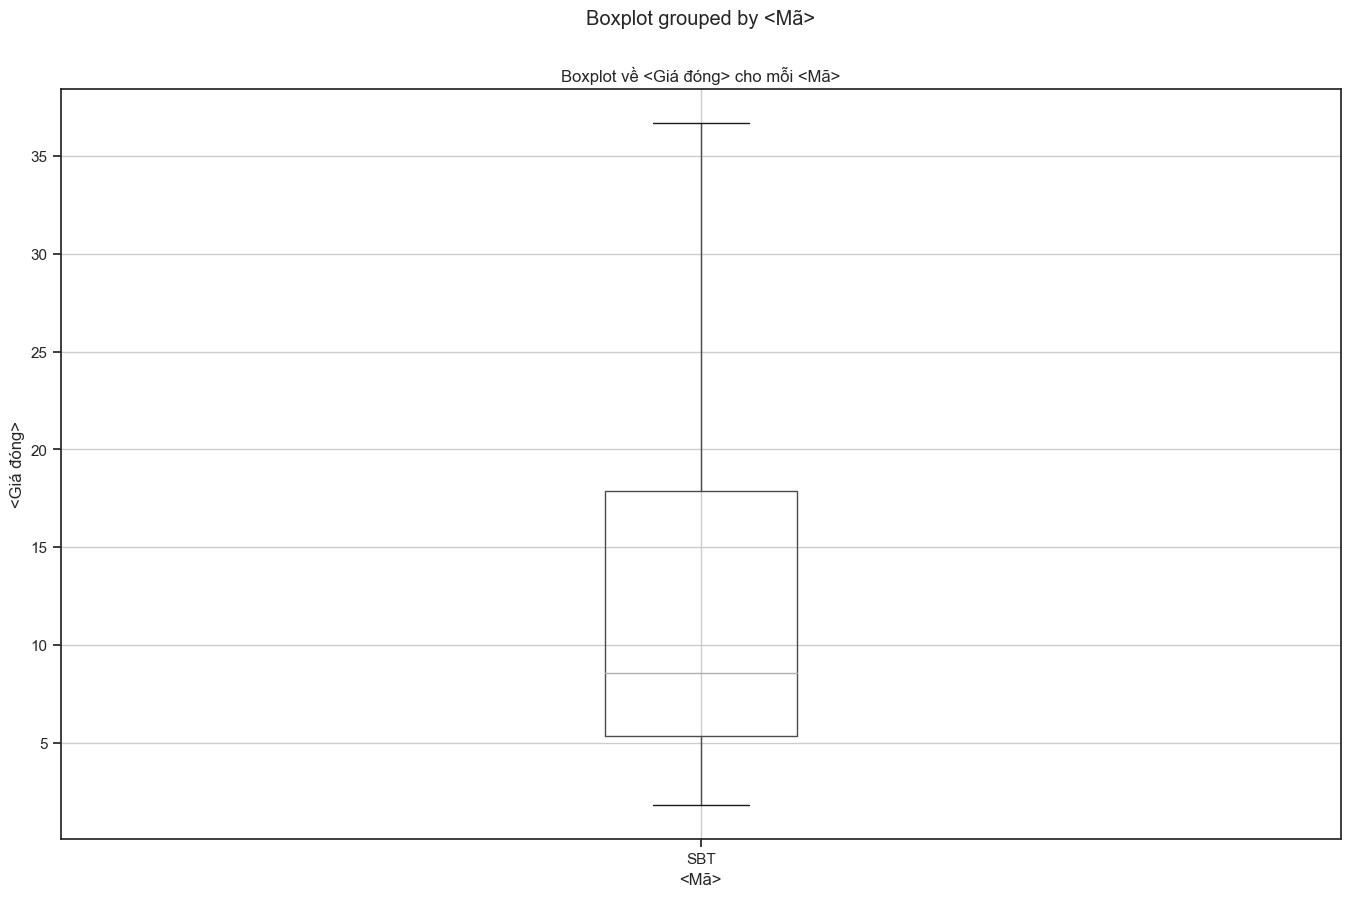

In [ ]:
plot_boxplot(filtered_df, column_name='<Giá đóng>', by_column='<Mã>')

#### Nhận xét:
- Những cổ phiếu có khoảng InterQuartile Range lớn nên số lượng outliers rất ít
- SAB có giá trị cao vượt trội so với các cổ phiếu khác
- Tương tự như giá đỉnh, SAB cũng thường có giá sàn cao hơn đáng kể so với các mã chứng khoán khác, trong khi POW lại có xu hướng có giá sàn thấp nhất.
- Trong mỗi phiên giao dịch, giá đóng của SAB thường cao hơn mức giá đóng của các mã khác, trong khi POW lại thường kết thúc với mức giá đóng thấp nhất. Điều này có thể phản ánh xu hướng hoạt động và cảm nhận của thị trường đối với hai mã này trong suốt phiên giao dịch.


## Scatterplot để trực quan dữ liệu

### Giá mở và giá đóng

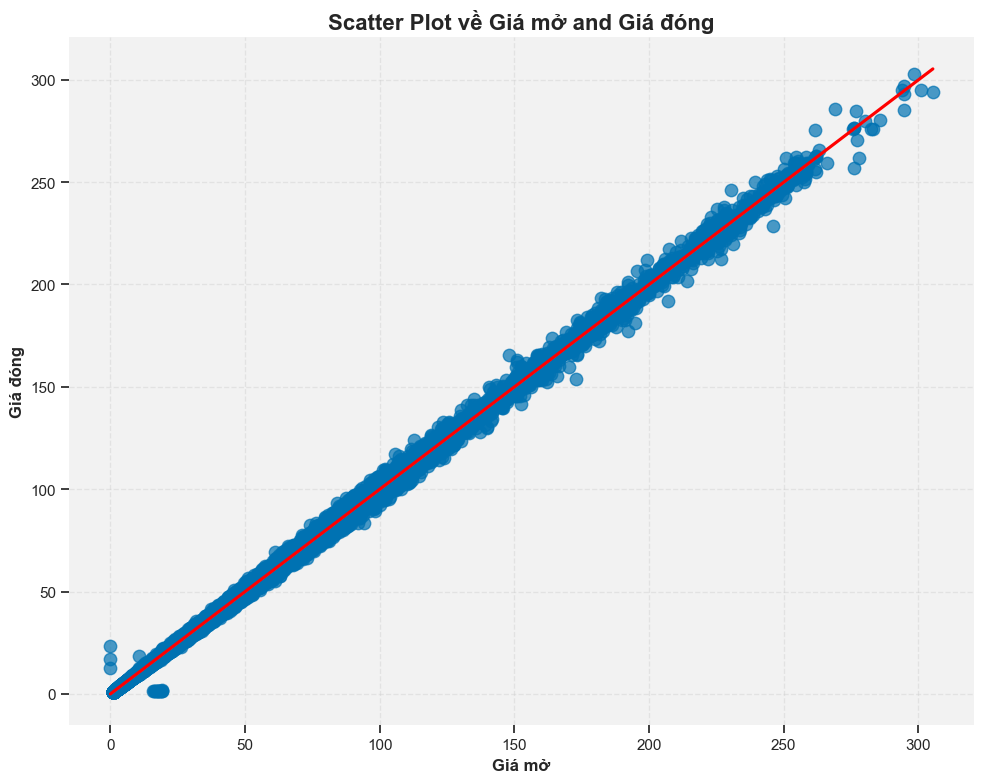

In [ ]:

sns.set_theme(style="ticks")
scatter_plot = sns.lmplot(x="<Giá mở>", y="<Giá đóng>", data=df, line_kws={"color": "red"},
                          scatter_kws={"color": "#0072B2", "alpha": 0.7, "s": 80})

plt.title("Scatter Plot về Giá mở and Giá đóng", fontweight='bold', fontsize=16)
plt.xlabel("Giá mở", fontweight='bold', fontsize=12)
plt.ylabel("Giá đóng", fontweight='bold', fontsize=12)


sns.despine(trim=True, left=True, bottom=True)
plt.grid(True, linestyle='--', alpha=0.4)

scatter_plot.ax.set_facecolor("#F2F2F2")

scatter_plot.fig.set_size_inches(10, 8)

plt.tight_layout()
plt.show()

#### Nhận xét:
- Mối quan hệ giữa giá mở và giá đóng thực sự là điểm đáng chú ý. Đường KDE (Kernel Density Estimation) hiển thị rằng phân phối của hai biến này khá gần với đường y = x, ngụ ý rằng có một mối liên kết chặt chẽ giữa giá mở và giá đóng. Điều này có thể chỉ ra rằng giá mở thường là một dấu hiệu tốt cho việc dự đoán giá đóng của cổ phiếu.

### Giá mở và khối lượng giao dịch

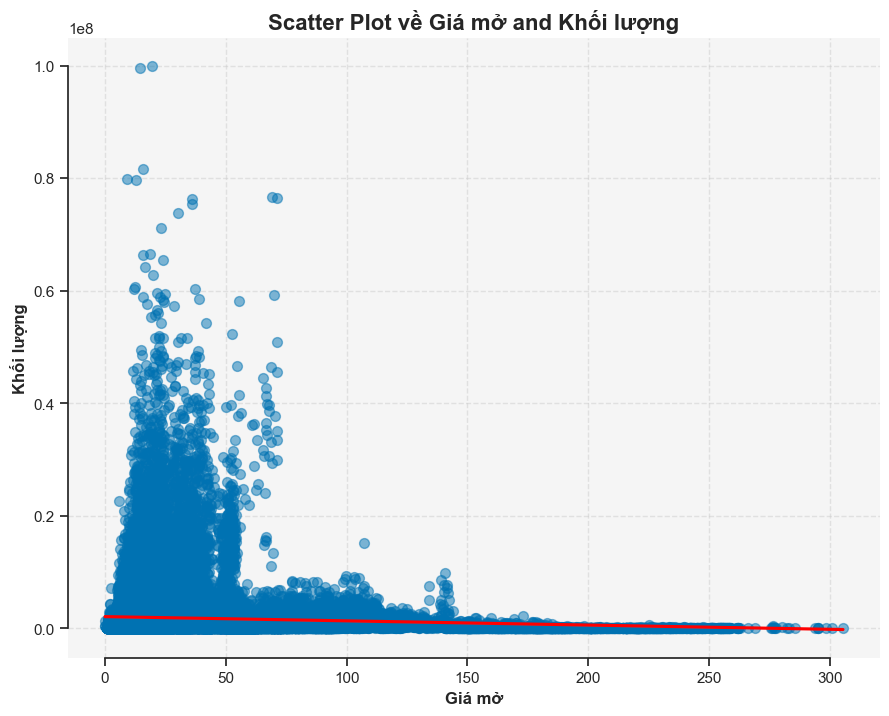

In [ ]:
sns.set(style="ticks")
sns.lmplot(x="<Giá mở>", y="<Khối lượng>", data=df, line_kws={"color": "red"}, scatter_kws={"color": "#0072B2", "alpha": 0.5, "s": 50})

plt.title("Scatter Plot về Giá mở and Khối lượng", fontweight='bold', fontsize=16)
plt.xlabel("Giá mở", fontweight='bold', fontsize=12)
plt.ylabel("Khối lượng", fontweight='bold', fontsize=12)

sns.despine(trim=True)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.gca().set_facecolor('#f5f5f5')

plt.gcf().set_size_inches(10, 8)
plt.show()

#### Nhận xét:
- Mối quan hệ giữa giá mở và khối lượng giao dịch đúng là đáng chú ý. Biểu đồ đã minh họa rõ ràng rằng khi giá mở tăng, thì khối lượng giao dịch thường giảm, và ngược lại. Điều này có thể phản ánh một cơ cấu thị trường tự nhiên, khi một cổ phiếu mở ở mức giá cao hơn, nhà đầu tư có thể trở nên kỳ vọng vào sự giảm giá và do đó quyết định mua vào ít hơn. Ngược lại, khi giá mở thấp, có thể kích thích sự quan tâm của nhà đầu tư và dẫn đến một lượng giao dịch lớn hơn.

### Chọn ra những cổ phiếu đặc trưng 'ACB', 'SAB', 'TCB', 'STB', 'CTG', 'SSI', 'MWG', 'NVL', 'PNJ', 'SBT' và xem xét với từng loại ta thấy

In [ ]:
tickers = ['ACB', 'SAB', 'TCB', \
           'STB', 'CTG', 'SSI', 'MWG', 'NVL', 'PNJ', 'SBT' ]

#### Mối quan hệ của Giá mở và giá đóng của từng cổ phiếu

In [ ]:
def scatter_plot_with_regression(x_values, y_values, ticker, x_label, y_label):
    plt.figure(figsize=(8, 5))
    plt.scatter(x_values, y_values, color="#0072B2")
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f'Scatter Plot - {ticker}')
    plt.plot(x_values, np.polyval(np.polyfit(x_values, y_values, 1), x_values), color='red')
    plt.show()


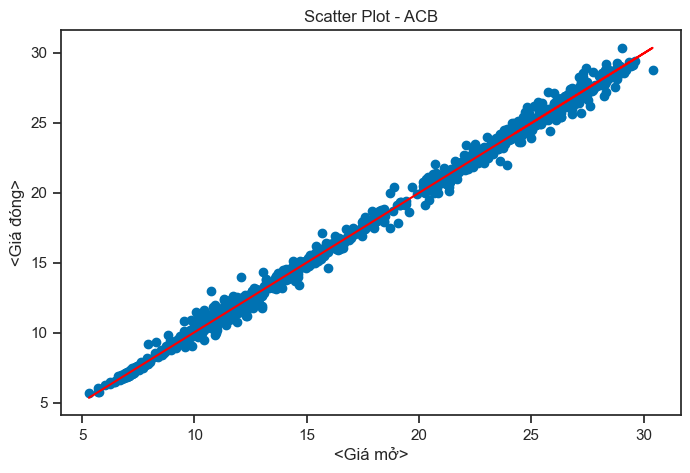

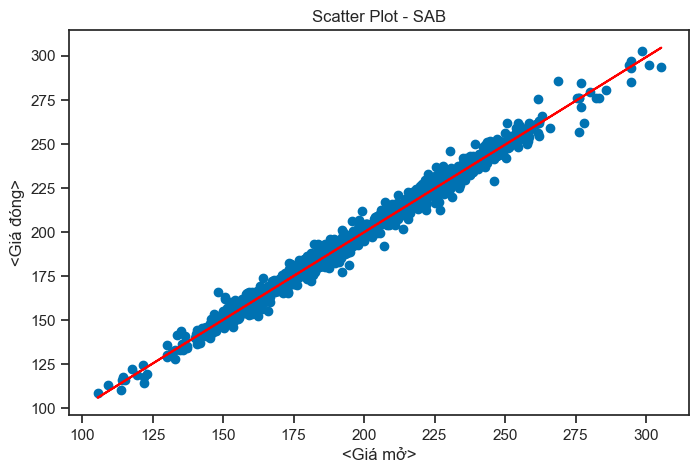

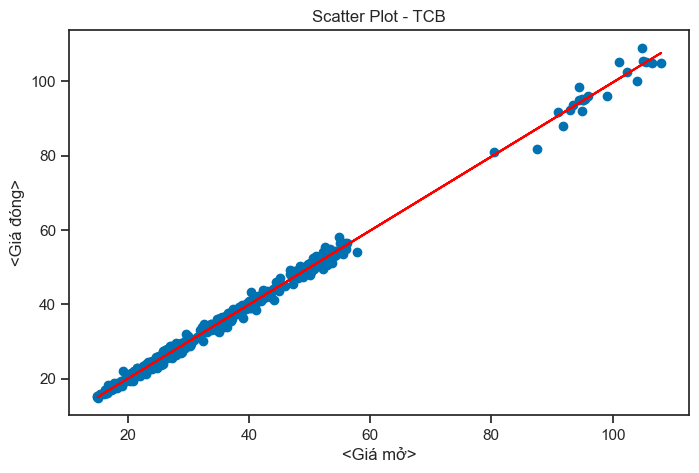

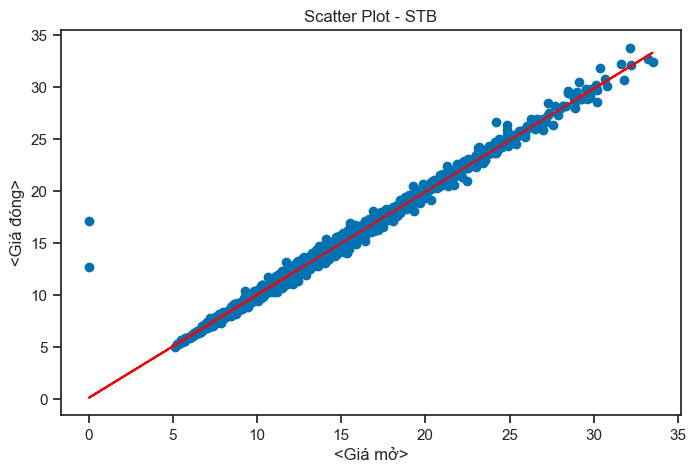

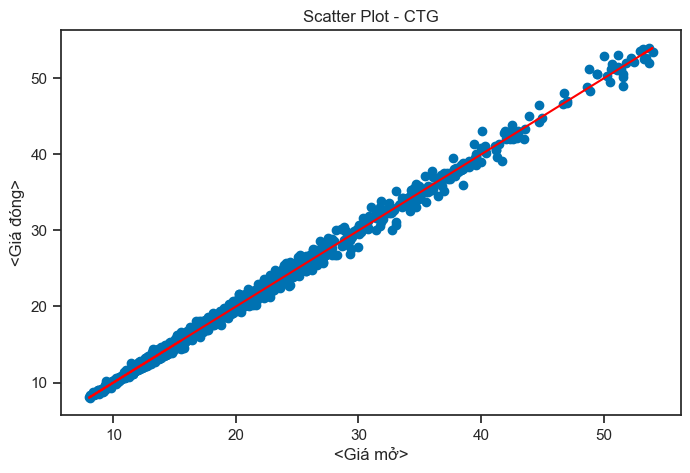

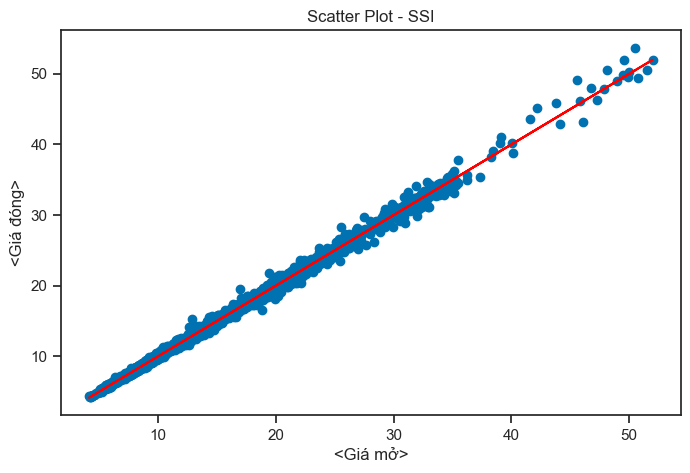

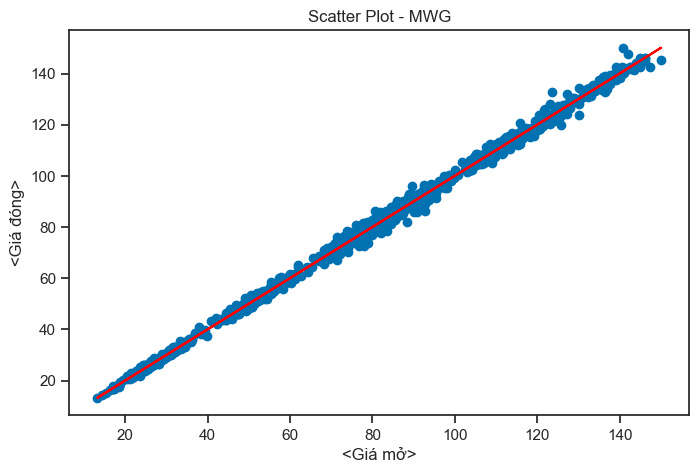

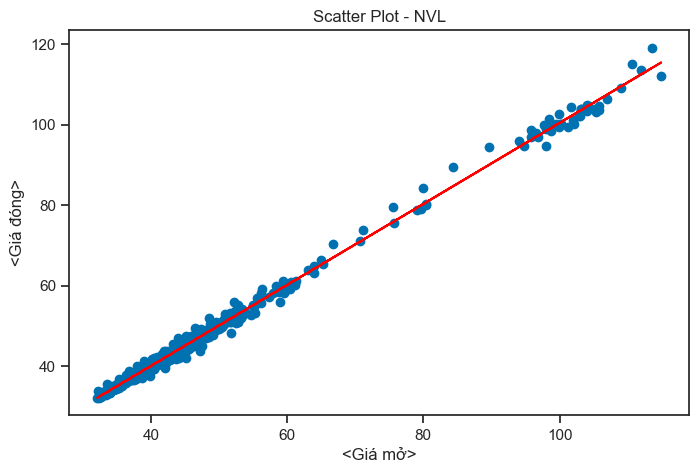

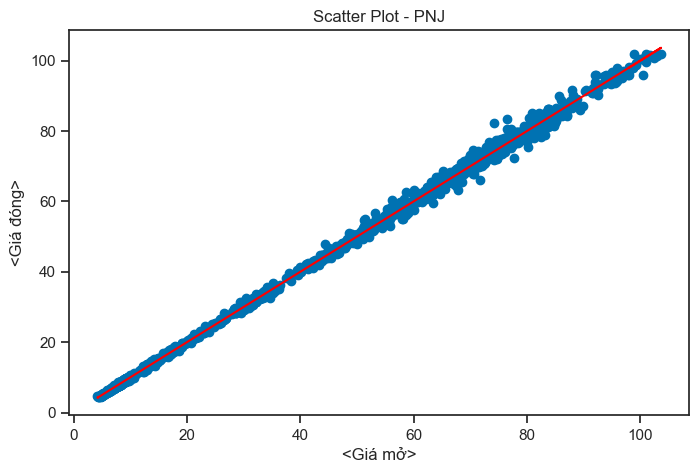

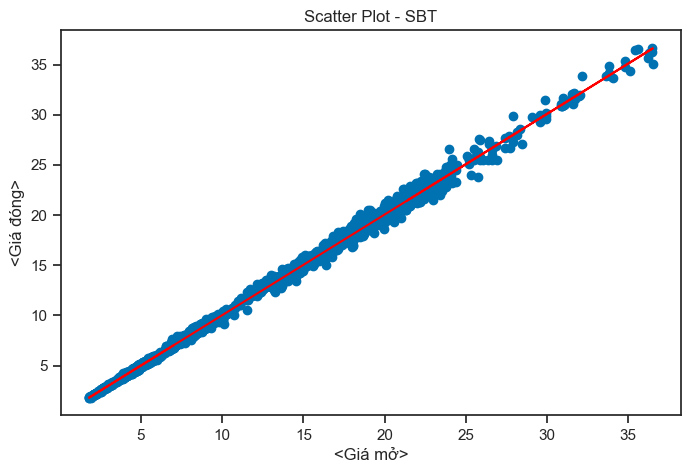

In [ ]:
for df, Mã in zip(corr_df, tickers):
    scatter_plot_with_regression(df['<Giá mở>'], df['<Giá đóng>'], Mã, '<Giá mở>', '<Giá đóng>')

#### Nhận xét:
- Giá mở và giá đóng của tất cả các cổ phiếu có sự tương quan dương (positive correlation).

#### Mối quan hệ của Giá mở và giá sàn của từng cổ phiếu

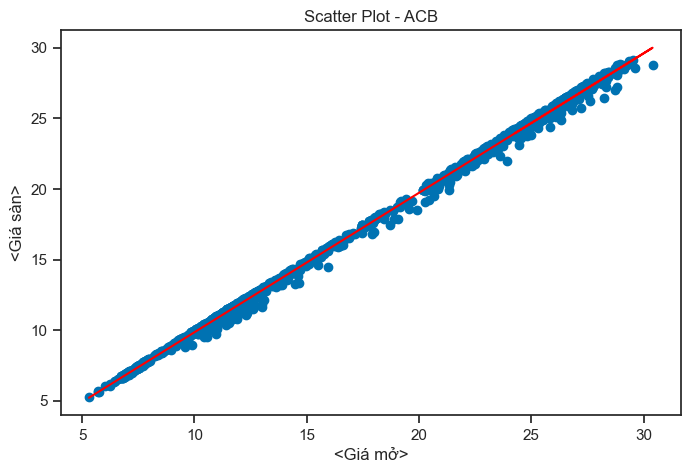

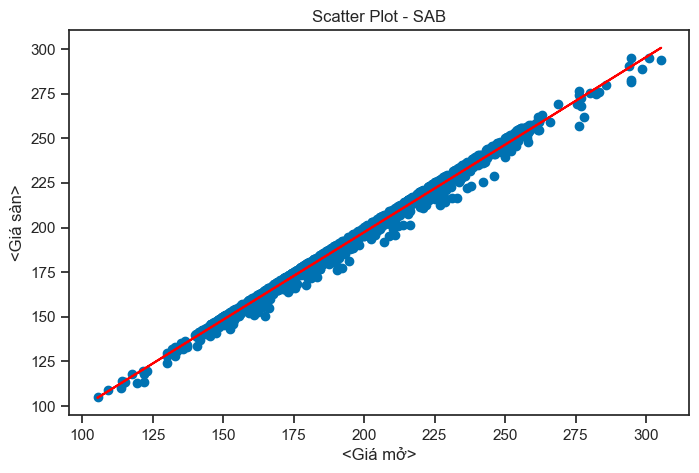

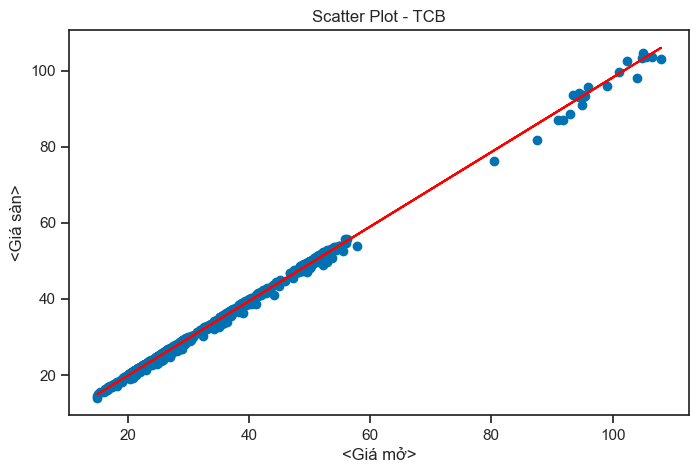

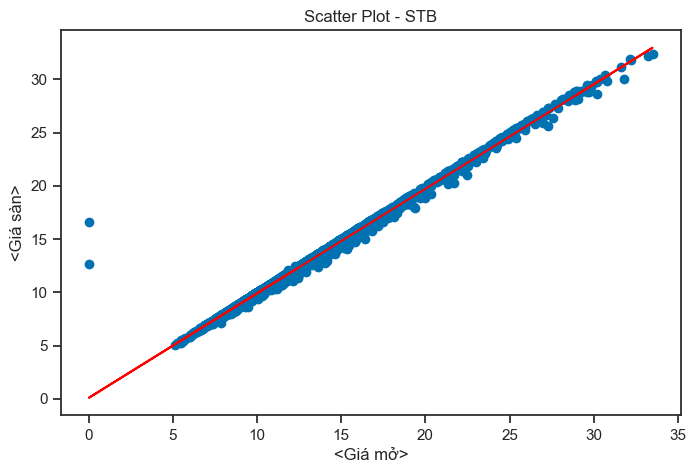

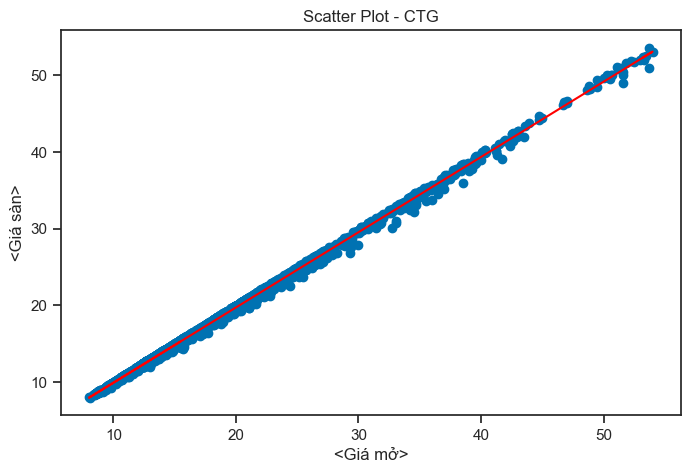

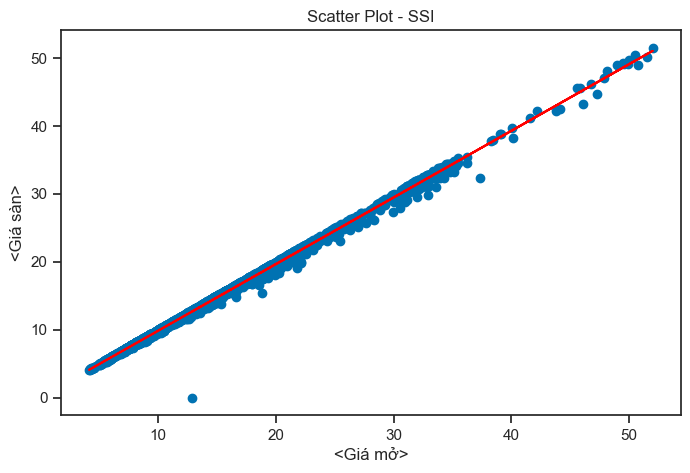

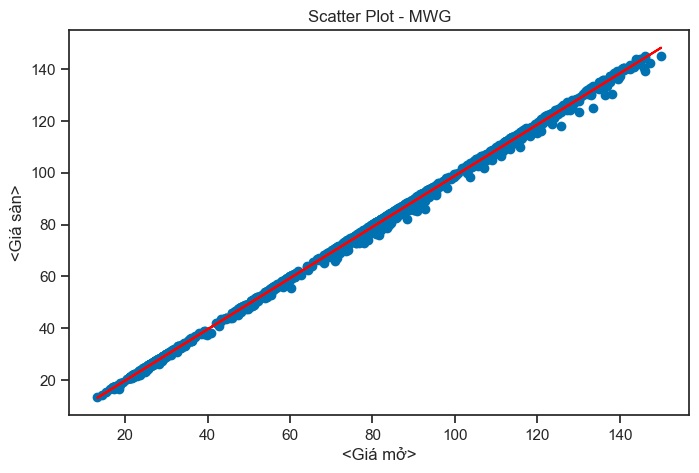

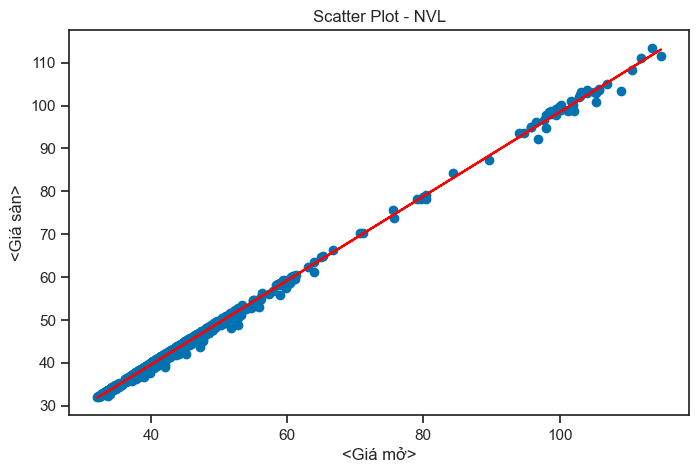

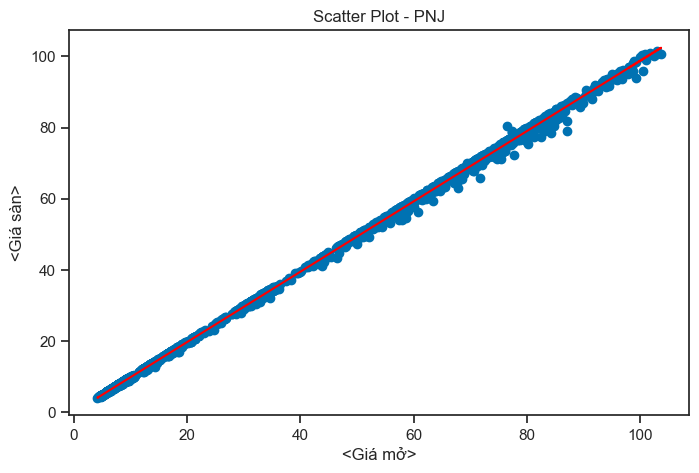

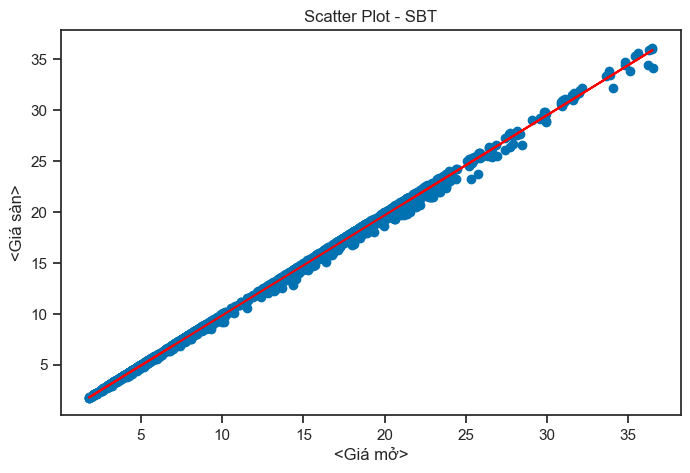

In [ ]:
for df, Mã in zip(corr_df, tickers):
    scatter_plot_with_regression(df['<Giá mở>'], df['<Giá sàn>'], Mã, '<Giá mở>', '<Giá sàn>')

#### Nhận xét:
- Giá mở và giá sàn của tất cả các cổ phiếu có sự tương quan dương (positive correlation).

#### Mối quan hệ của Giá mở và giá đỉnh của từng cổ phiếu

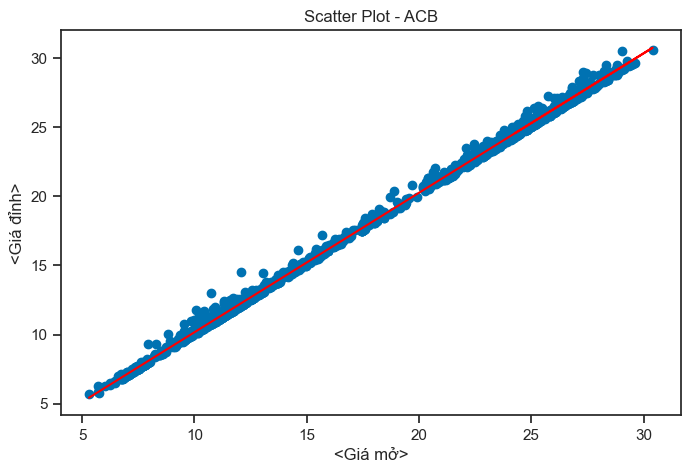

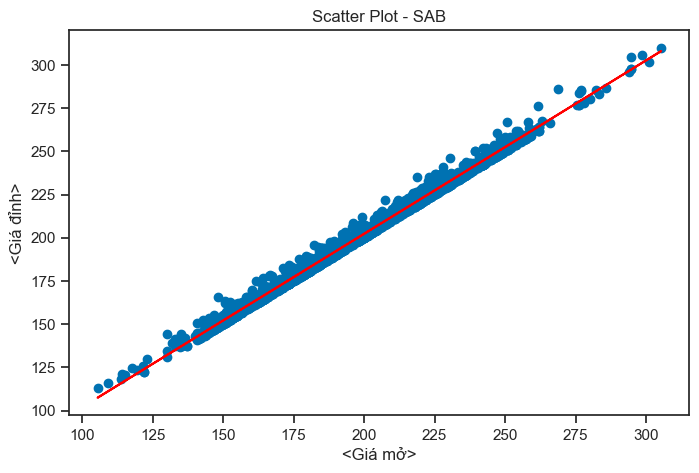

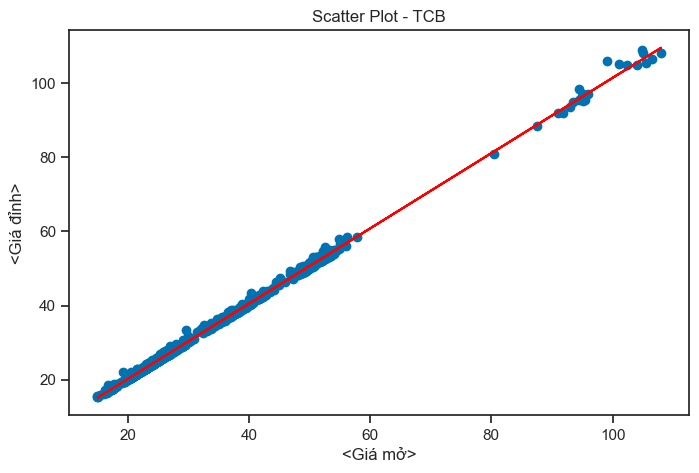

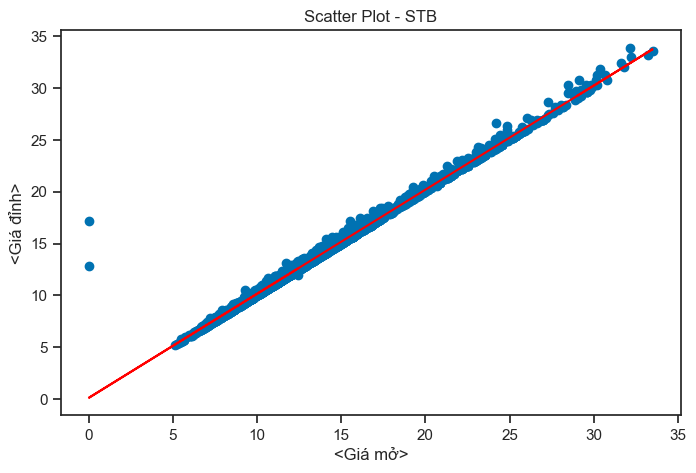

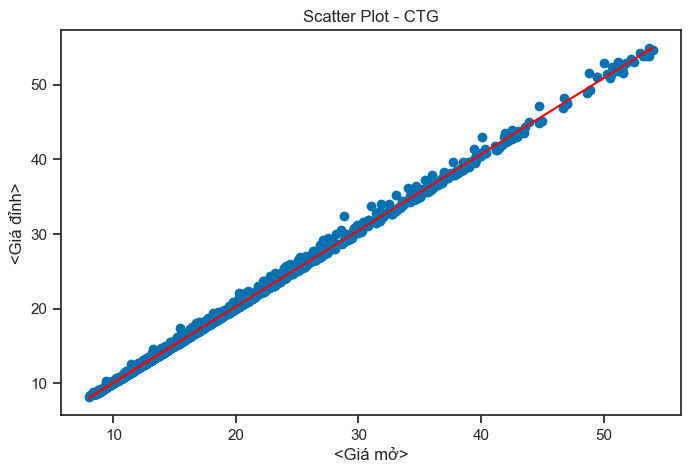

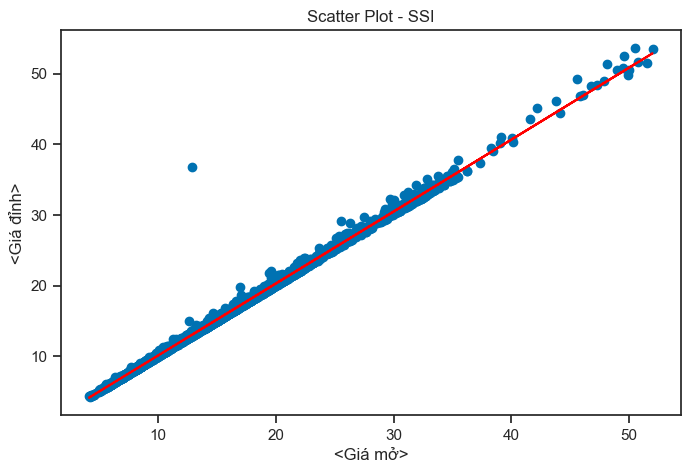

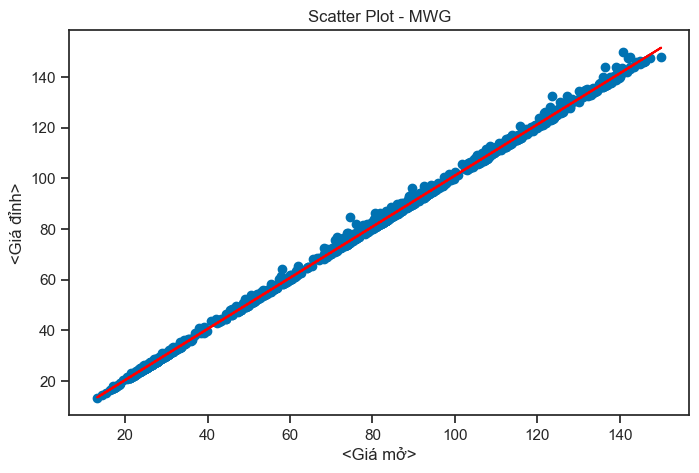

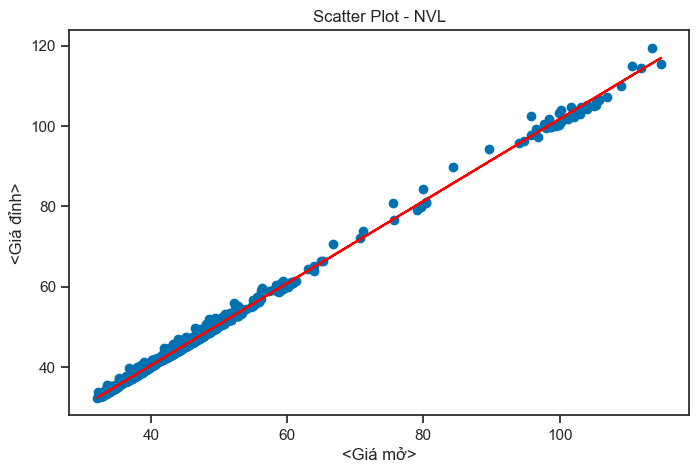

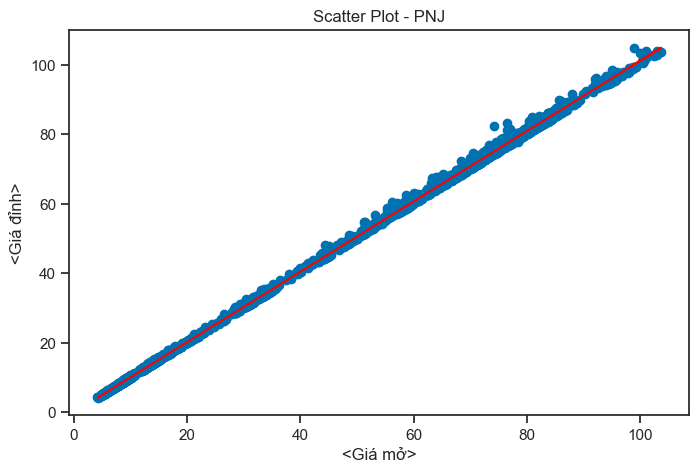

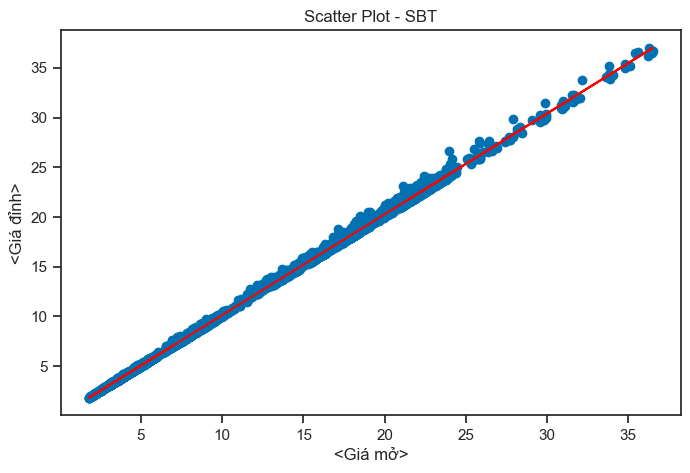

In [ ]:
for df, Mã in zip(corr_df, tickers):
    scatter_plot_with_regression(df['<Giá mở>'], df['<Giá đỉnh>'], Mã, '<Giá mở>', '<Giá đỉnh>')

#### Nhận xét:
- Giá mở và giá đỉnh của tất cả các cổ phiếu có sự tương quan dương (positive correlation).

#### Mối quan hệ của Giá đỉnh và giá sàn của từng cổ phiếu

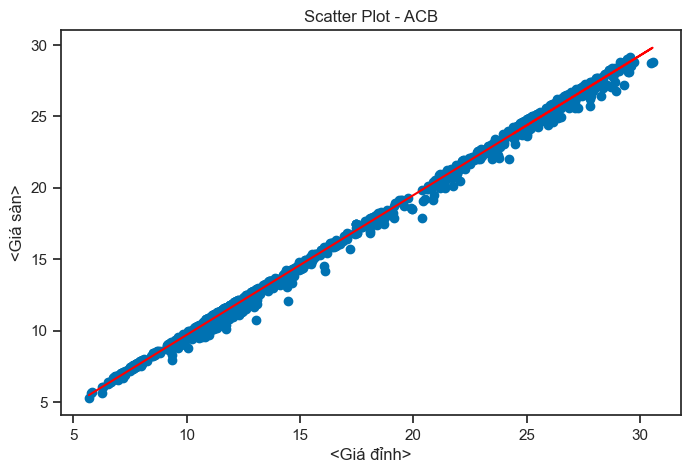

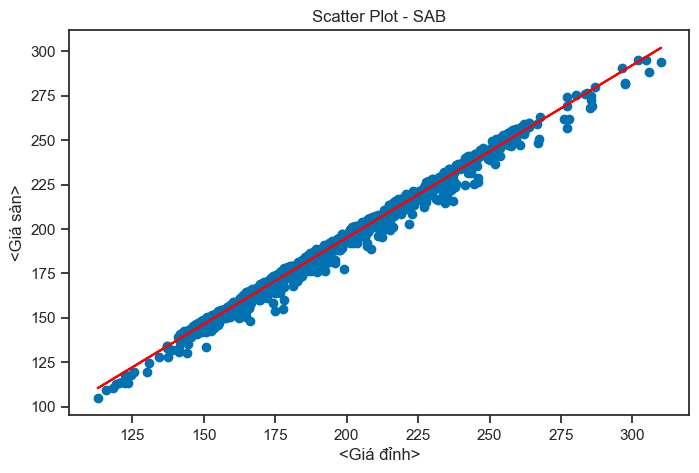

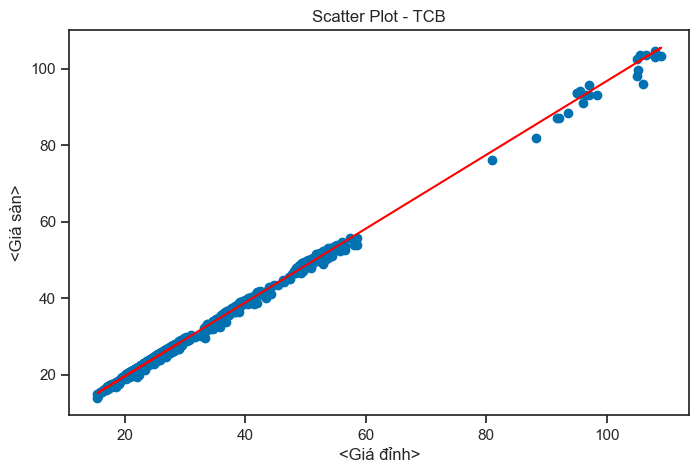

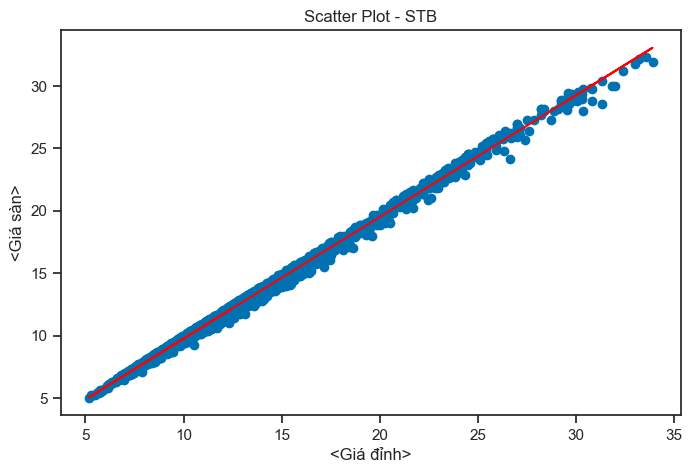

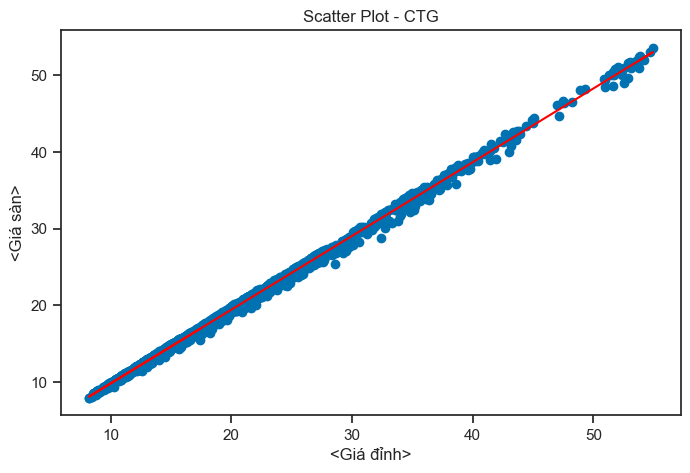

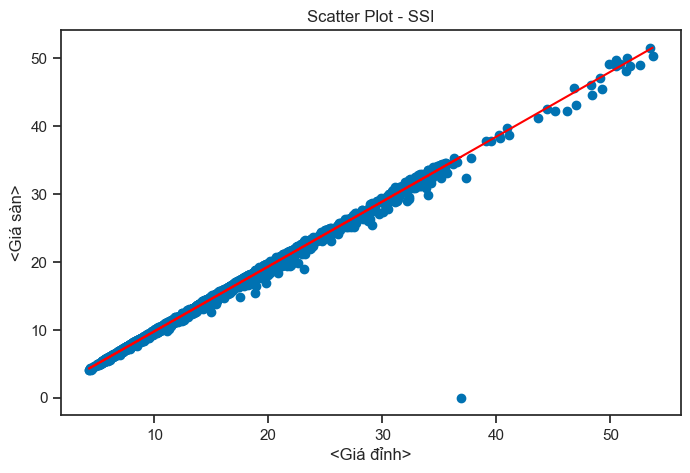

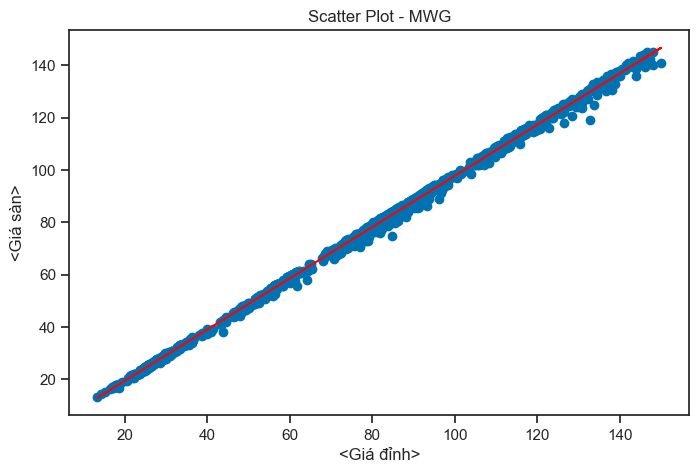

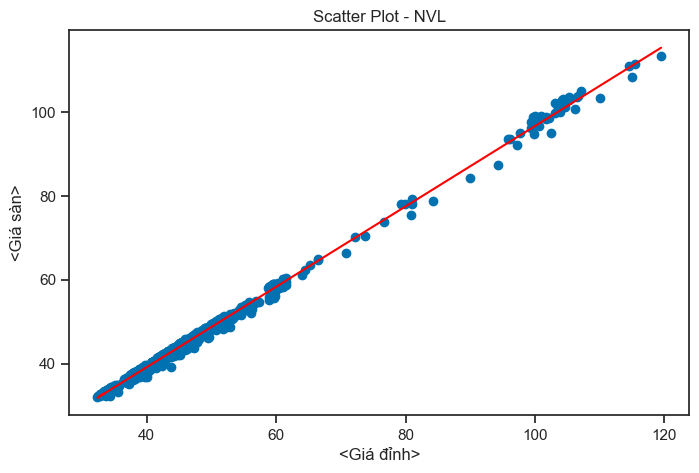

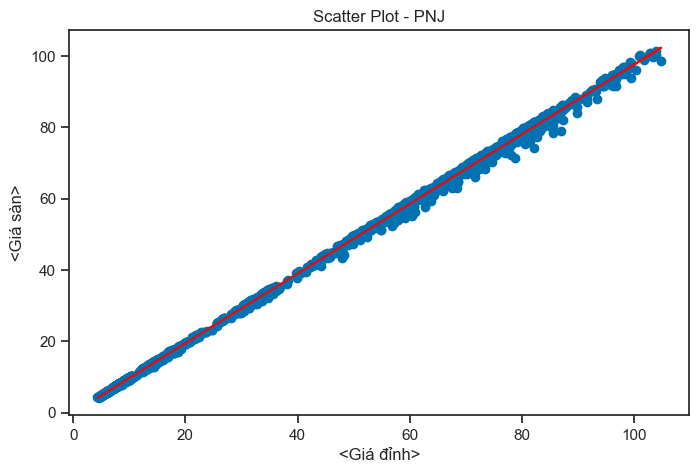

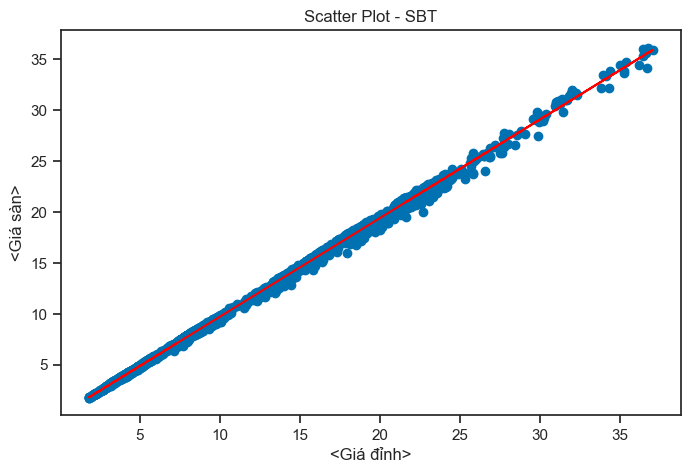

In [ ]:
for df, Mã in zip(corr_df, tickers):
    scatter_plot_with_regression(df['<Giá đỉnh>'], df['<Giá sàn>'], Mã, '<Giá đỉnh>', '<Giá sàn>')

#### Nhận xét:
- Giá đỉnh và giá sàn của tất cả các cổ phiếu có sự tương quan dương (positive correlation).

#### Mối quan hệ của Ngày và giá mở của từng cổ phiếu

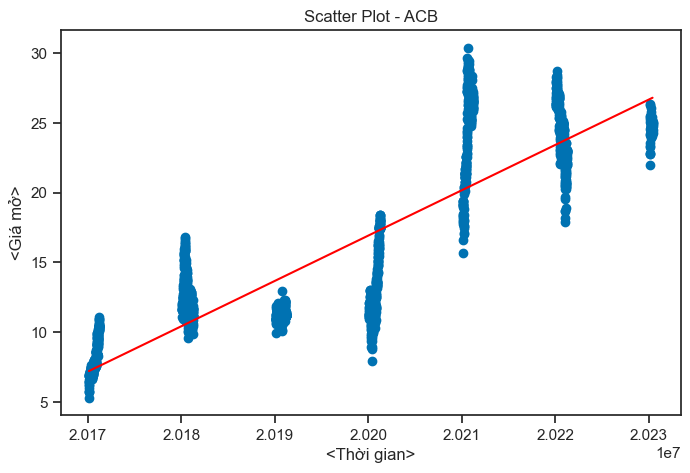

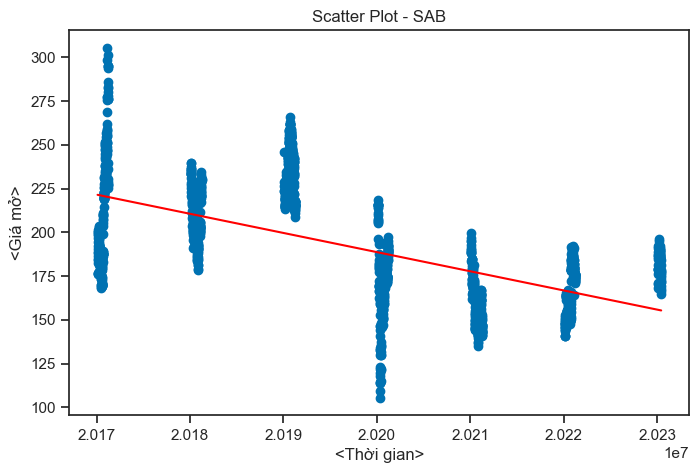

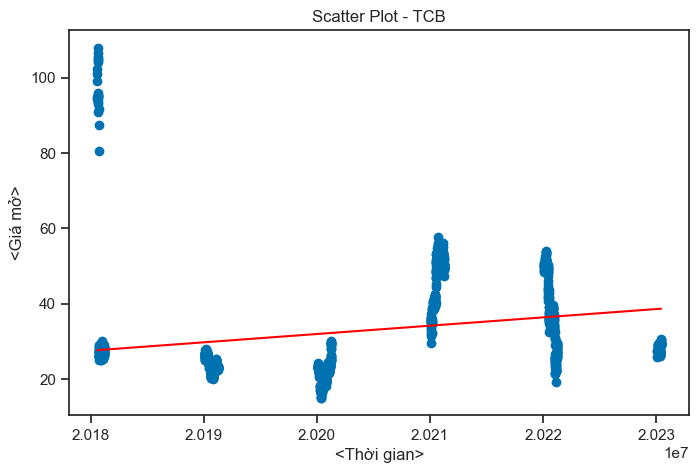

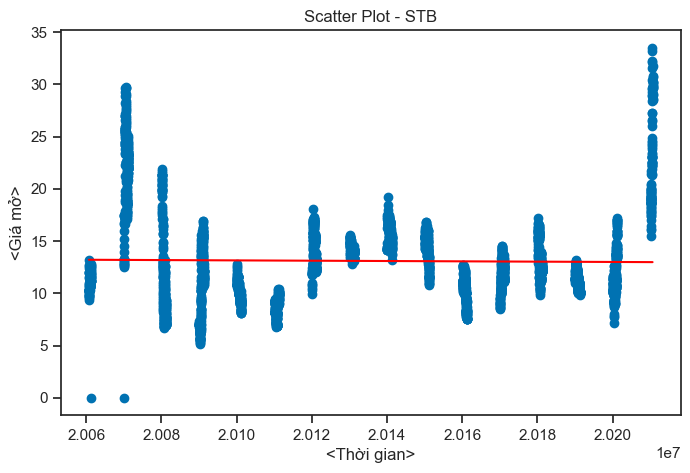

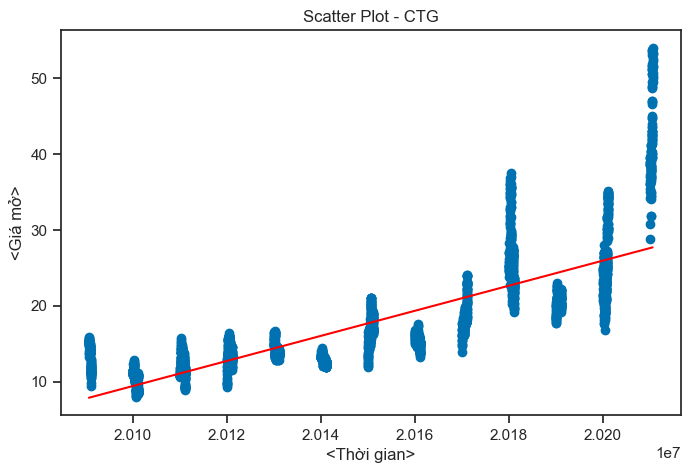

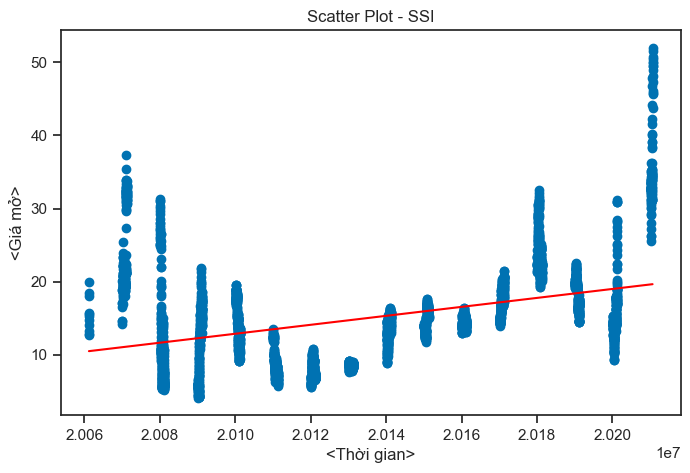

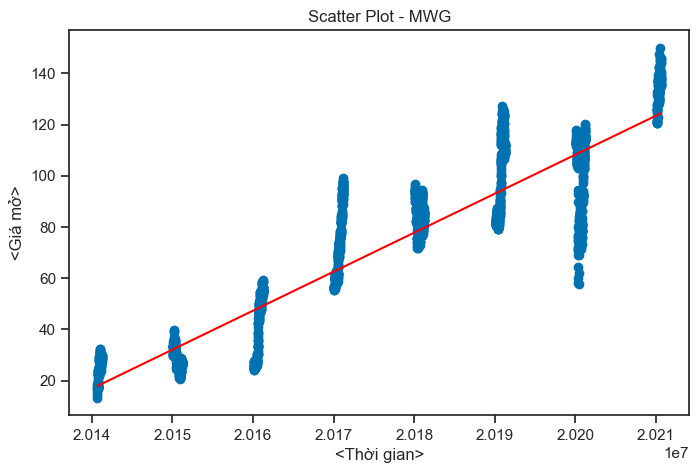

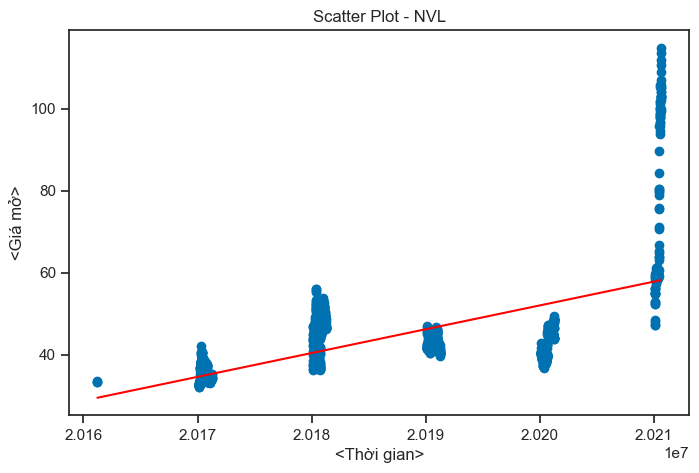

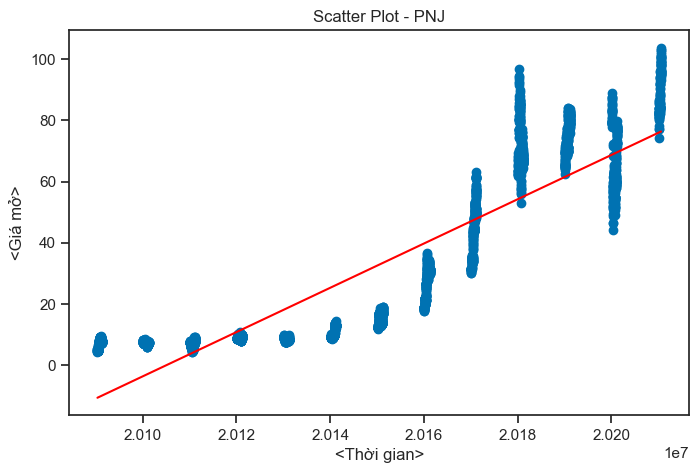

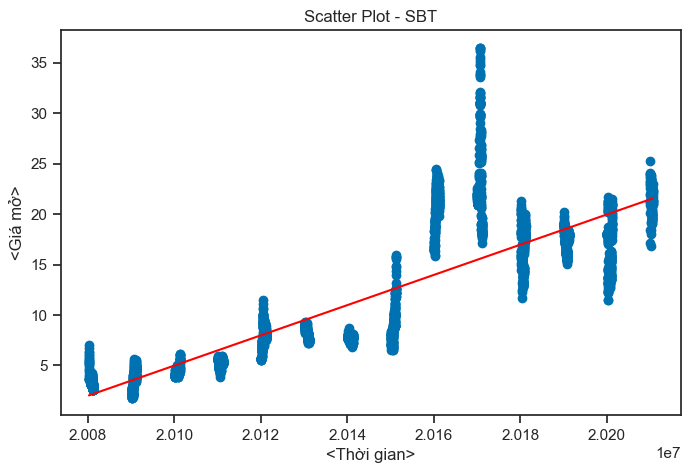

In [ ]:
for df, Mã in zip(corr_df, tickers):
    scatter_plot_with_regression(df['<Thời gian>'], df['<Giá mở>'], Mã, '<Thời gian>', '<Giá mở>')

#### Mối quan hệ của Ngày và giá đóng của từng cổ phiếu

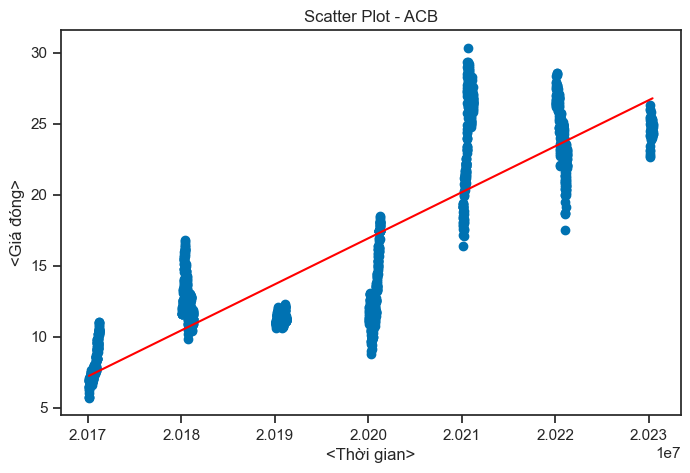

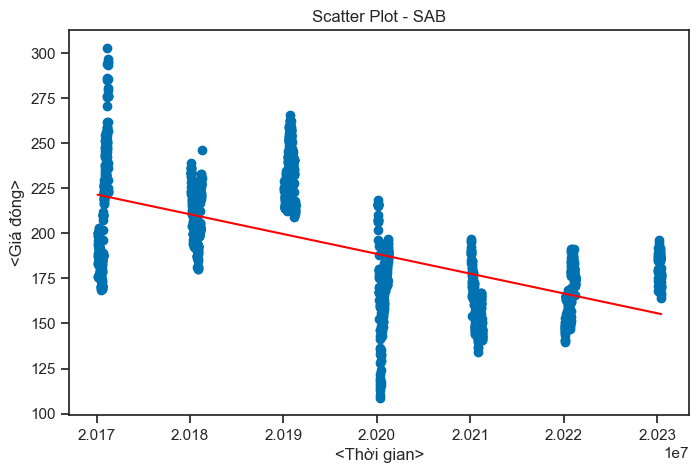

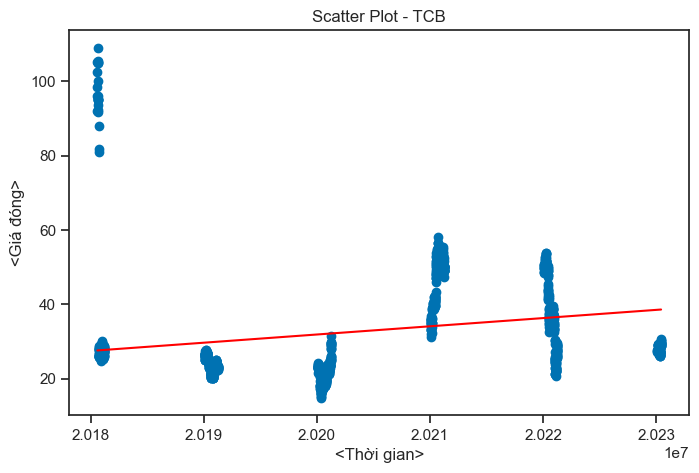

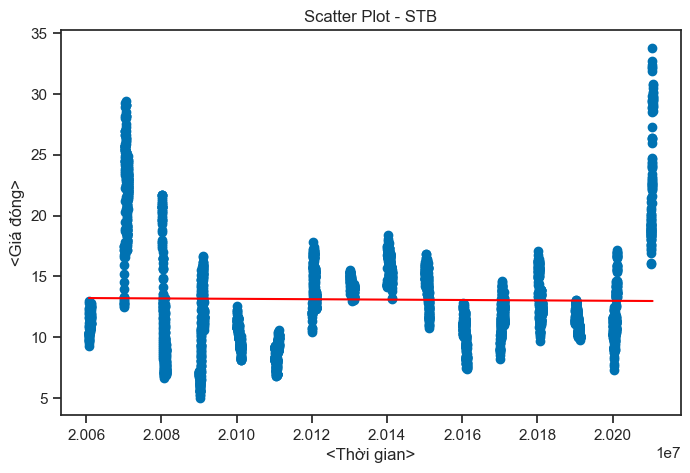

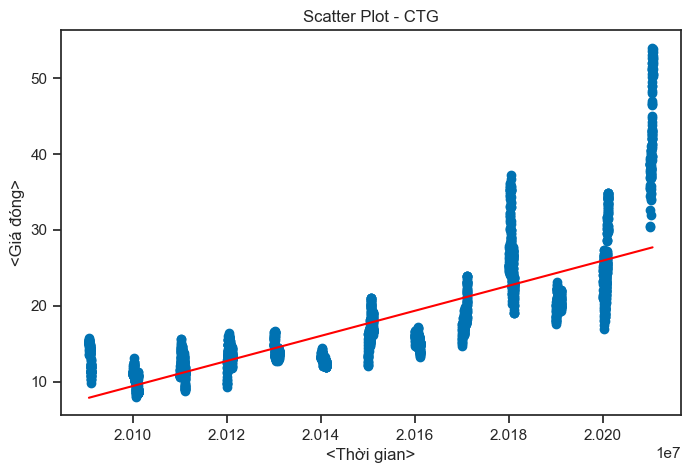

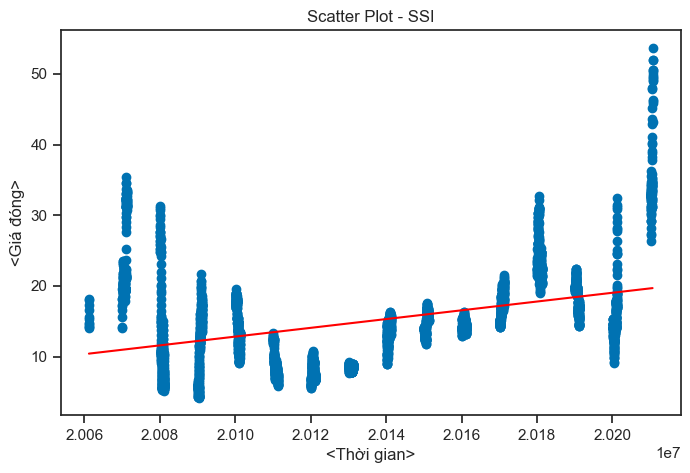

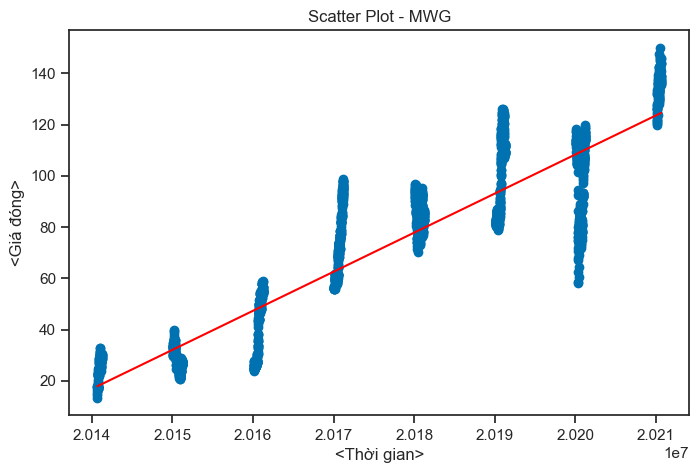

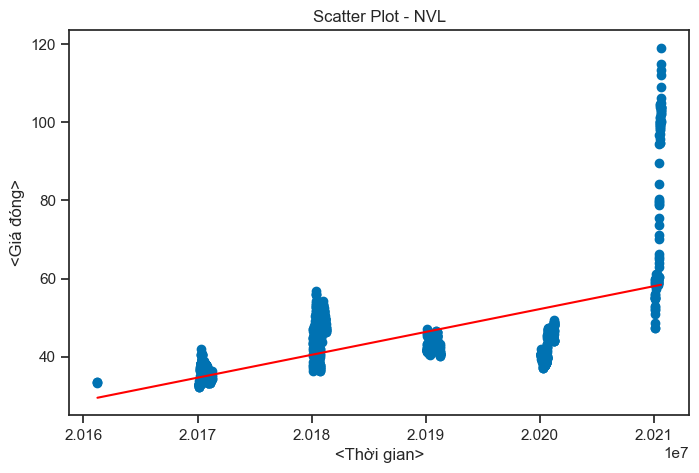

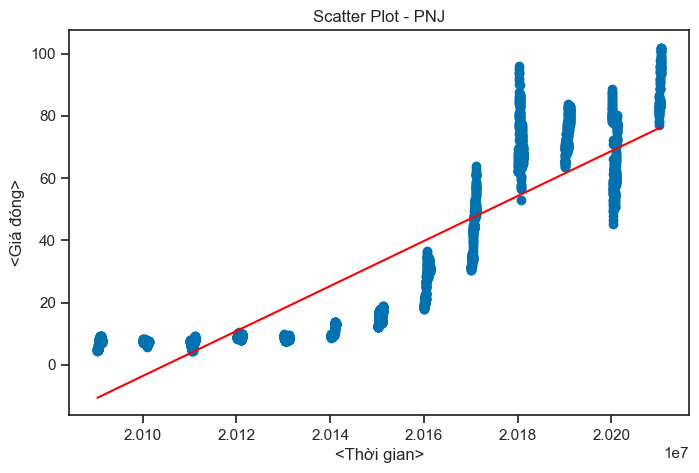

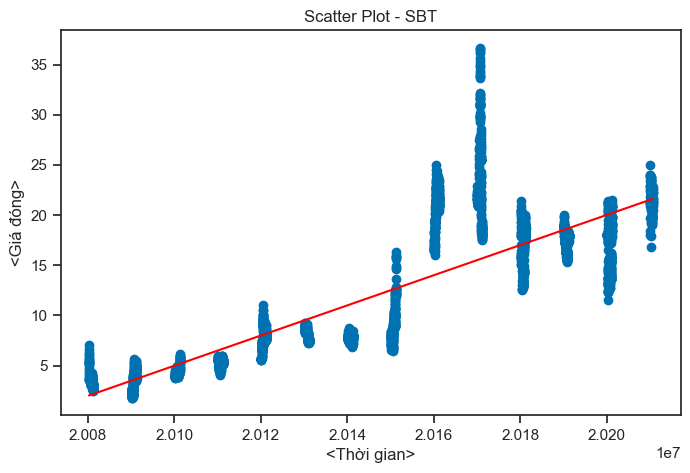

In [ ]:
for df, Mã in zip(corr_df, tickers):
    scatter_plot_with_regression(df['<Thời gian>'], df['<Giá đóng>'], Mã, '<Thời gian>', '<Giá đóng>')

### Nhận xét:
- Một só cổ phiếu có sự tương quan đồng biến cao giữa giá mở và ngày như: VCB, BID, FPT
- Cổ phiếu có sự giảm giá mở theo thời gian là SAB

# III. Phân tích tính hồi quy, giải thích và dự đoán

### Thực hiện đọc lại dữ liệu và đem cột thời gian làm index

In [ ]:
date_parser = lambda x: datetime.strptime(x, '%Y%m%d')

data = pd.read_csv('stock.csv', parse_dates=['<DTYYYYMMDD>'], date_parser=date_parser)

data.set_index('<DTYYYYMMDD>', inplace=True)

In [ ]:
stb_df = data.loc[data['<Ticker>'] == 'STB']
acb_df = data.loc[data['<Ticker>'] == 'ACB']
ctg_df = data.loc[data['<Ticker>'] == 'CTG']
ssi_df = data.loc[data['<Ticker>'] == 'SSI']
mwg_df = data.loc[data['<Ticker>'] == 'MWG']
nvl_df = data.loc[data['<Ticker>'] == 'NVL']
pnj_df = data.loc[data['<Ticker>'] == 'PNJ']
sbt_df = data.loc[data['<Ticker>'] == 'SBT']
sab_df = data.loc[data['<Ticker>'] == 'SAB']
tcb_df = data.loc[data['<Ticker>'] == 'TCB']

#### Thực hiện lấy những giá trị đặc trưng cho bộ dữ liệu

In [ ]:
corr_df = [acb_df, sab_df, tcb_df, stb_df, ctg_df, ssi_df, mwg_df, nvl_df, pnj_df, sbt_df]

tickers = ['ACB', 'SAB', 'TCB', \
           'STB', 'CTG', 'SSI', 'MWG', 'NVL', 'PNJ', 'SBT' ]

ACB 



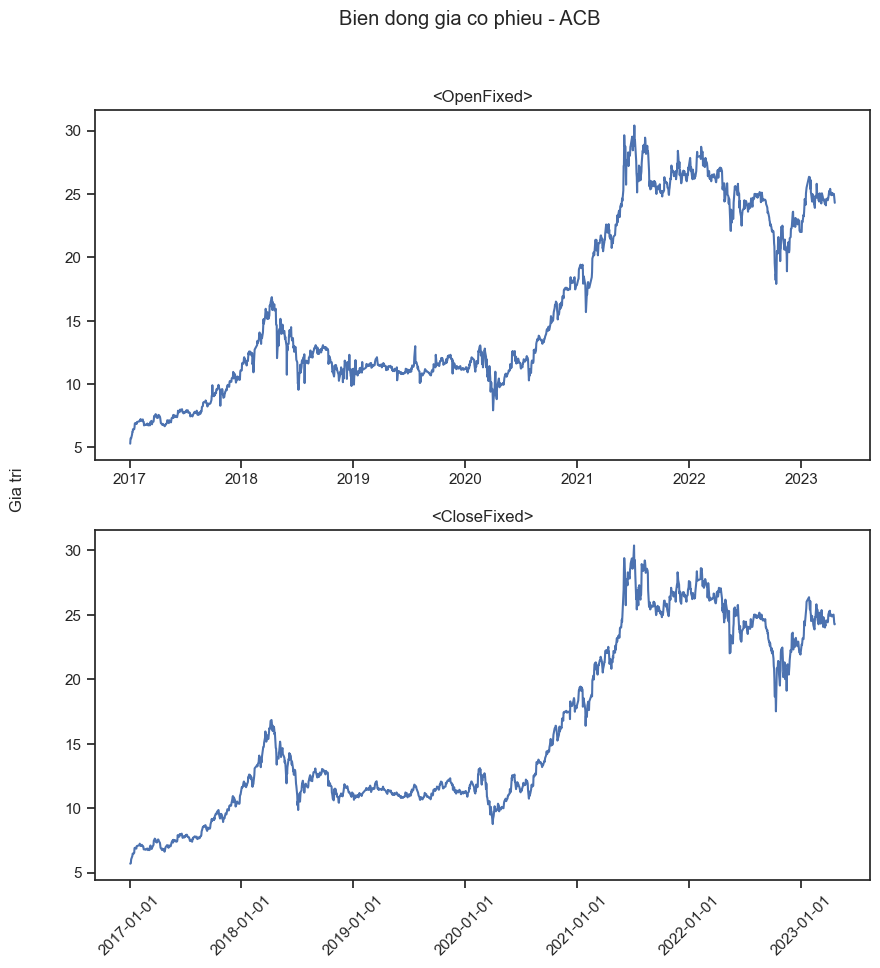

SAB 



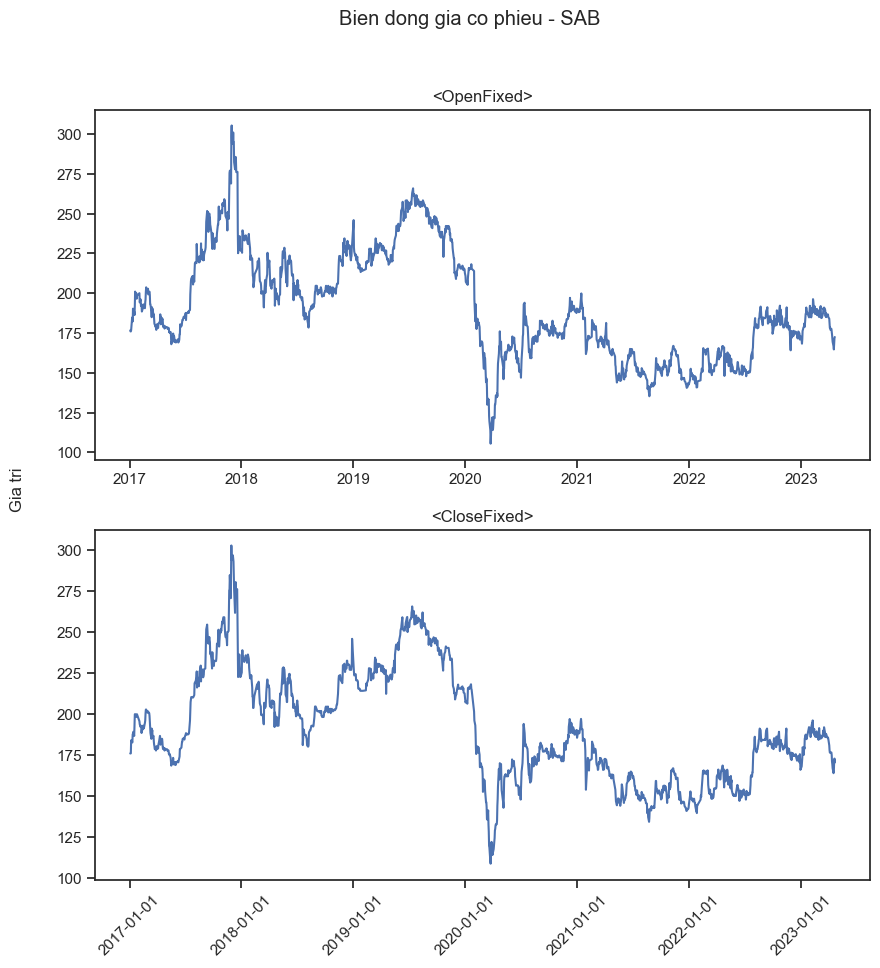

TCB 



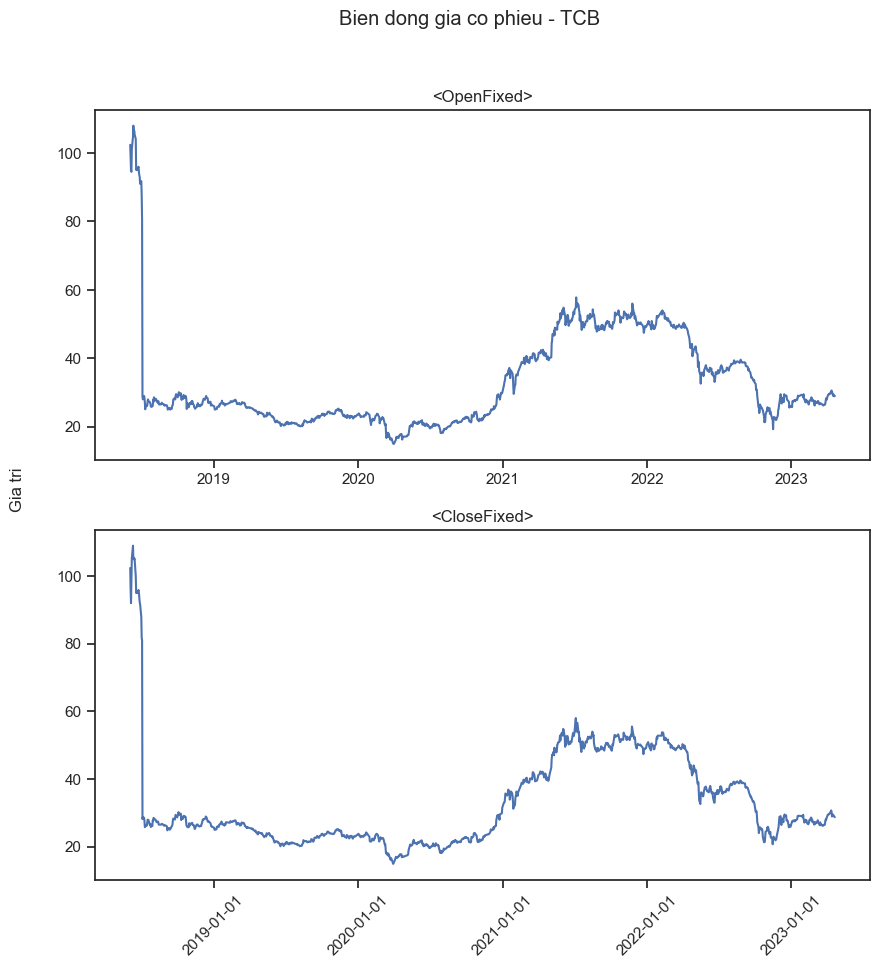

STB 



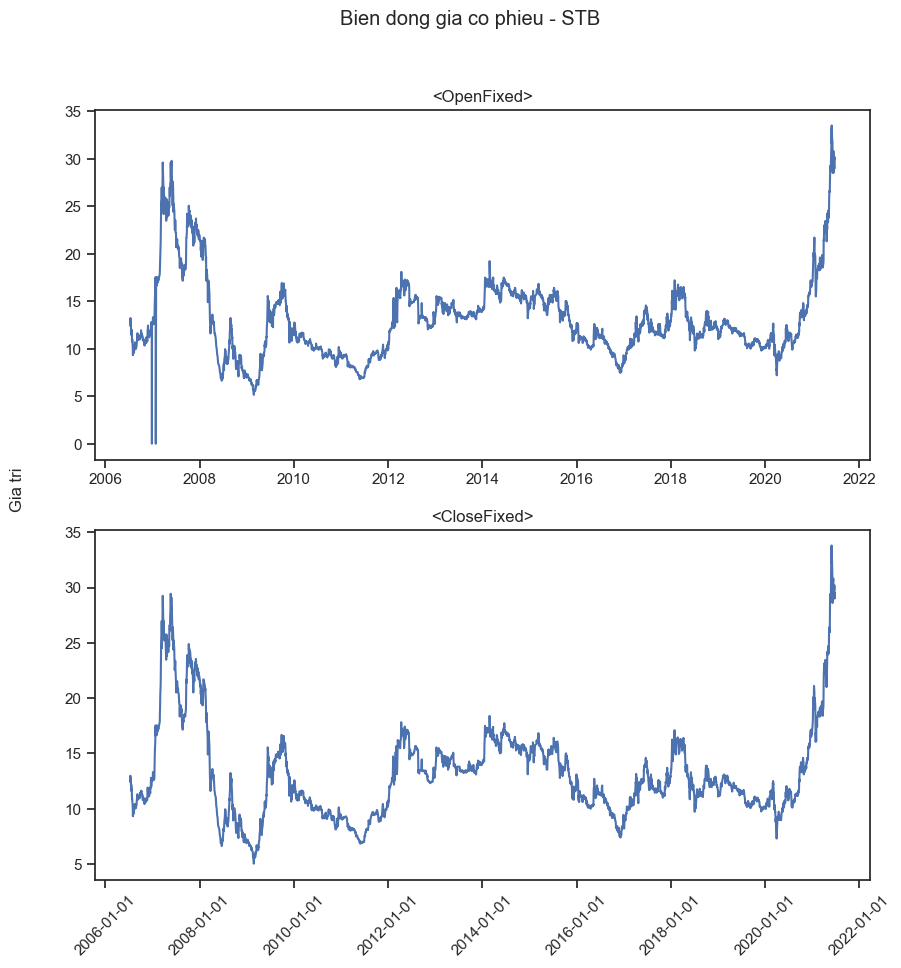

CTG 



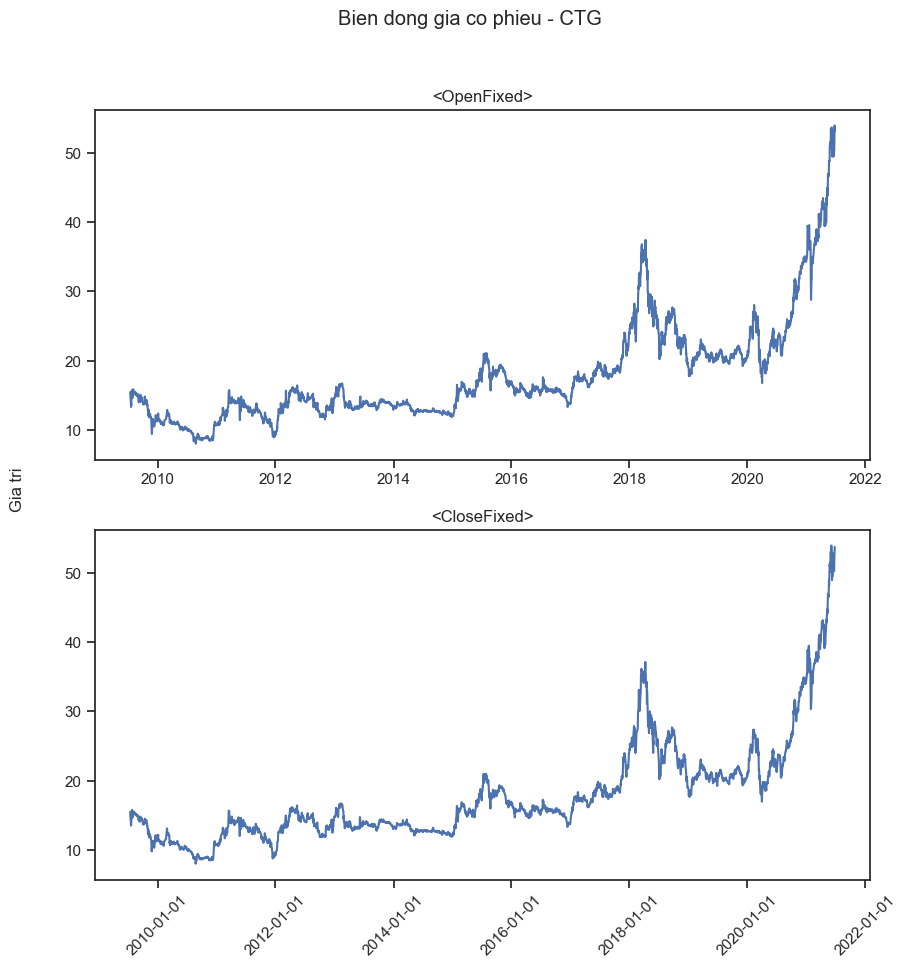

SSI 



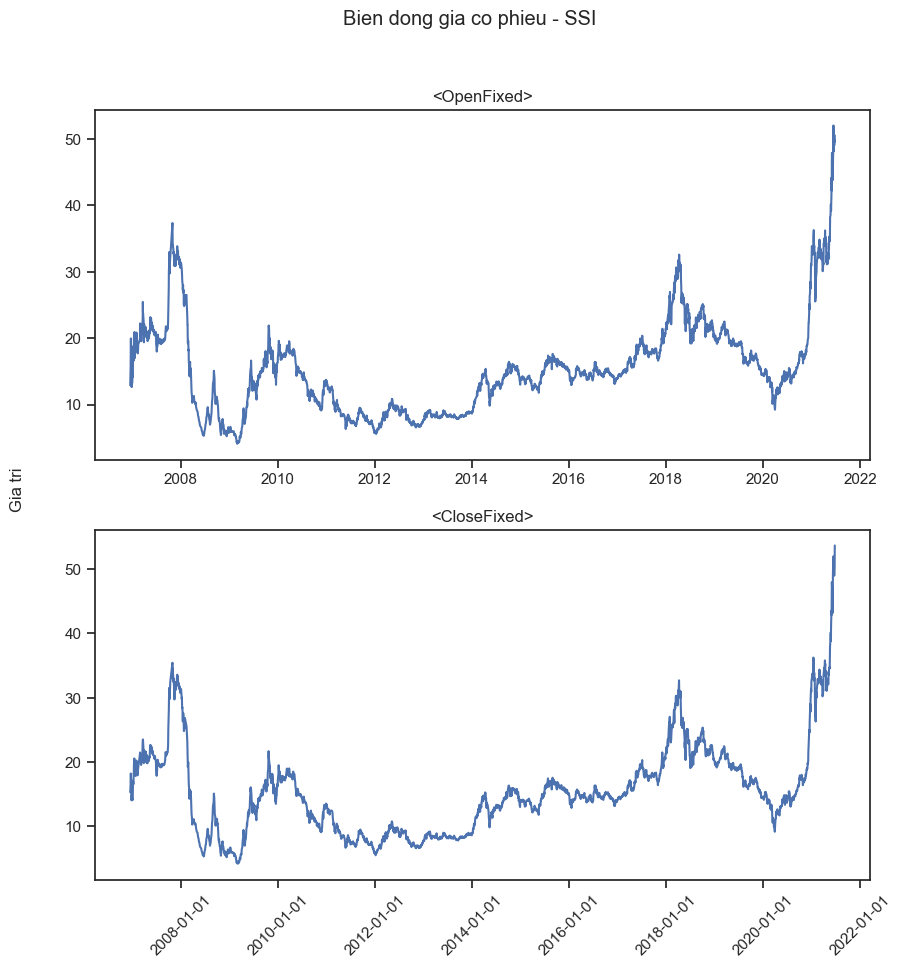

MWG 



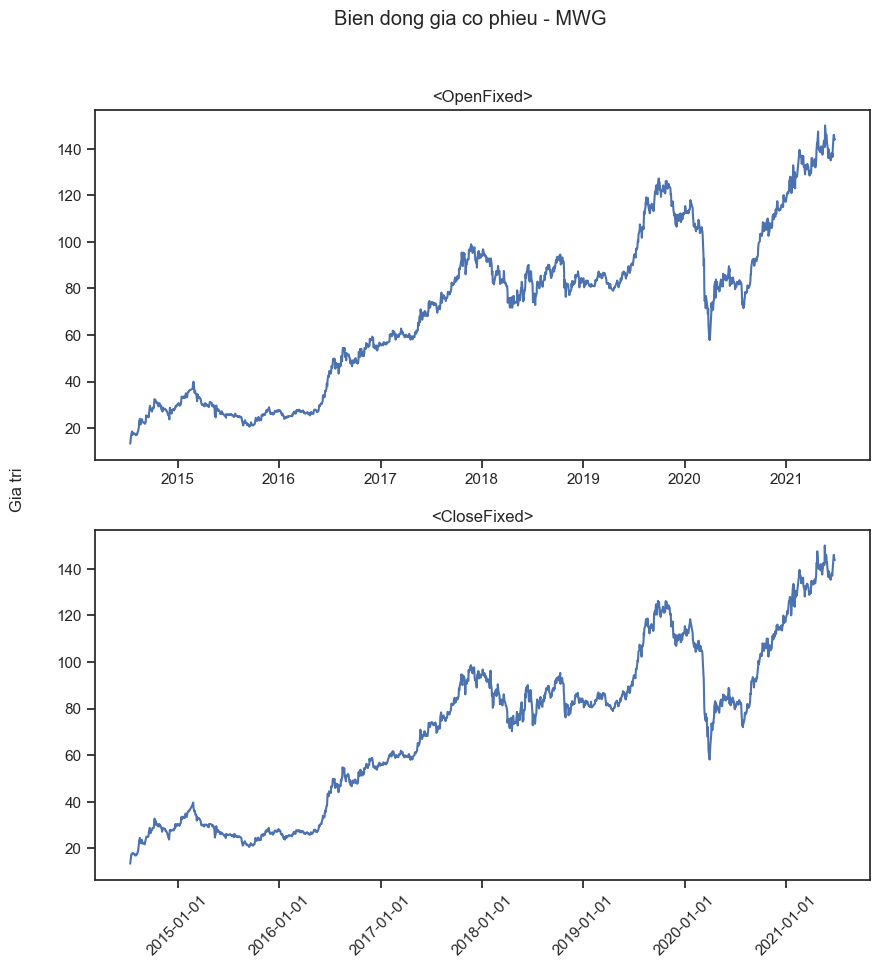

NVL 



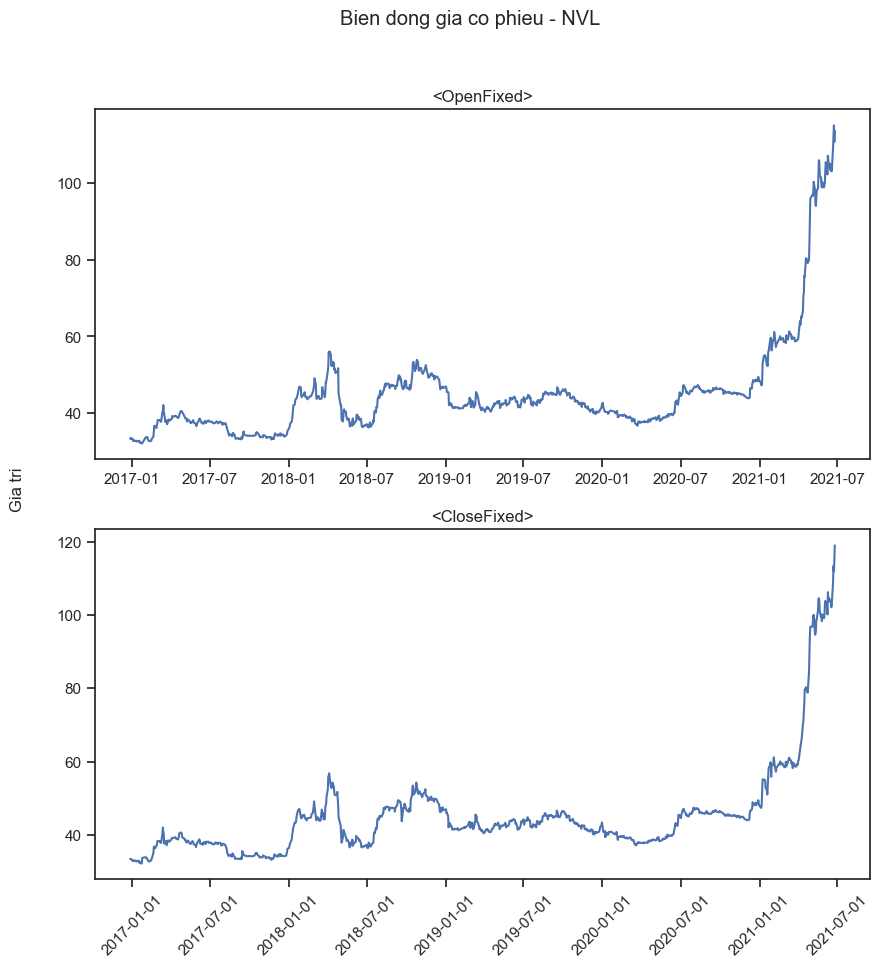

PNJ 



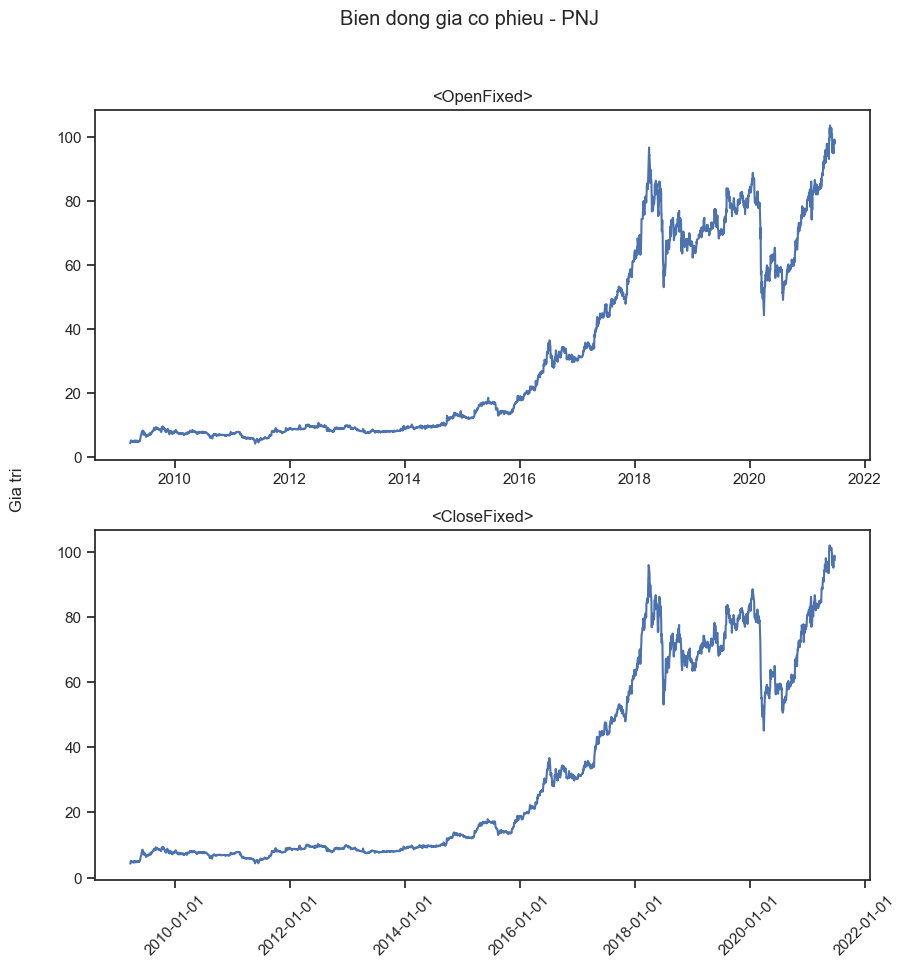

SBT 



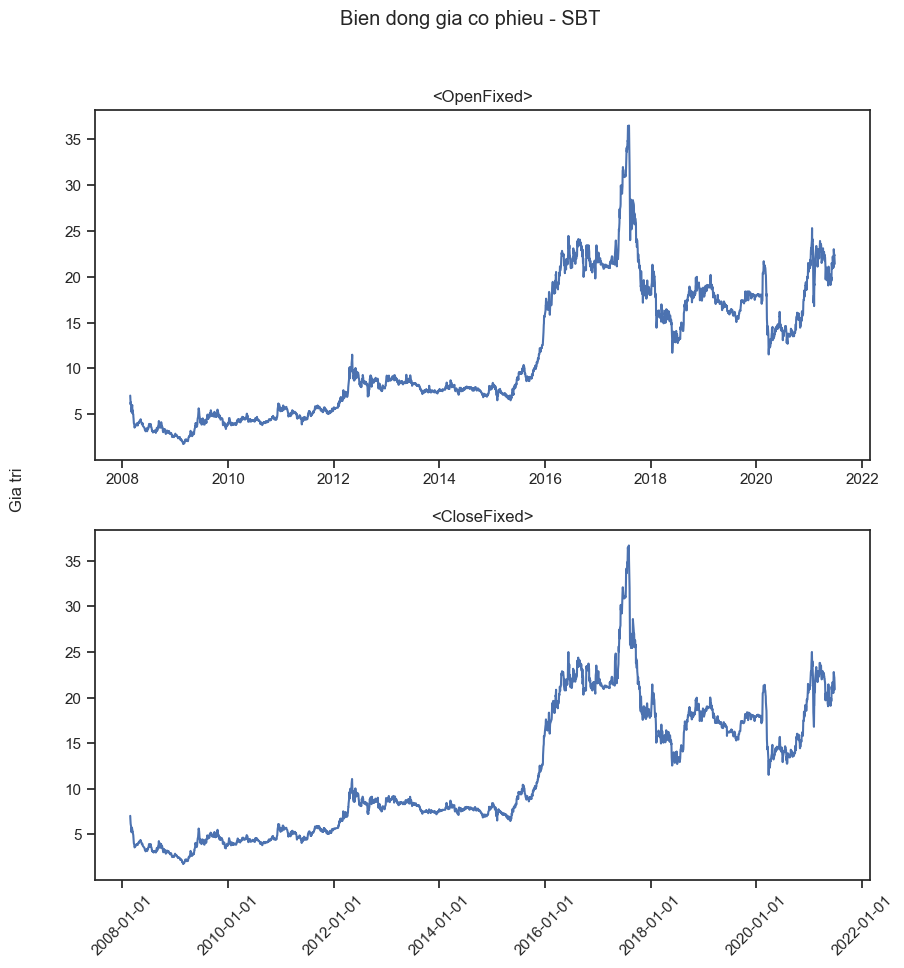

In [ ]:
for df, ticker in zip(corr_df, tickers):
    print(ticker,'\n')
    fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    axs[0].plot(df.index, df['<OpenFixed>'])
    axs[0].set_title('<OpenFixed>')
    axs[1].plot(df.index, df['<CloseFixed>'])
    axs[1].set_title('<CloseFixed>')
    fig.text(0.04, 0.5, 'Gia tri', va='center', rotation='vertical')
    fig.suptitle(f'Bien dong gia co phieu - {ticker}')
    date_format = '%Y-%m-%d'
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter(date_format))
    plt.show()

#### Nhận xét
- Qua các năm, biến động giá cổ phiếu đã trải qua một hành trình tích cực, thể hiện xu hướng tăng trưởng ổn định. Tuy nhiên, điều đáng chú ý là giai đoạn từ 2019 đến 2021 đã chứng kiến sự giảm sút đáng kể trong sự phát triển này. Nguyên nhân chính có thể là do tác động mạnh mẽ của đại dịch COVID-19 đối với nền kinh tế Việt Nam. Đại dịch này đã gây ra sự đình trệ trong nhiều hoạt động xã hội và làm giảm mạnh dòng tiền đầu tư.

- Trong giai đoạn khó khăn này, chính phủ và các cơ quan chức năng đã thực hiện nhiều biện pháp nhằm hỗ trợ kinh tế và ổn định thị trường. Tuy nhiên, năm 2022 được xem là bước đi tích cực khi tình hình kinh tế bắt đầu ổn định hơn, nhờ vào nỗ lực khắc phục dịch bệnh COVID-19 của quốc gia. Sự ổn định này tiếp tục được củng cố và phát triển vào năm 2023, khi nền kinh tế mở cửa trở lại, tạo điều kiện thuận lợi cho dòng tiền đầu tư và kích thích nhu cầu phát triển.

In [ ]:
acb_df = acb_df[['<CloseFixed>']]

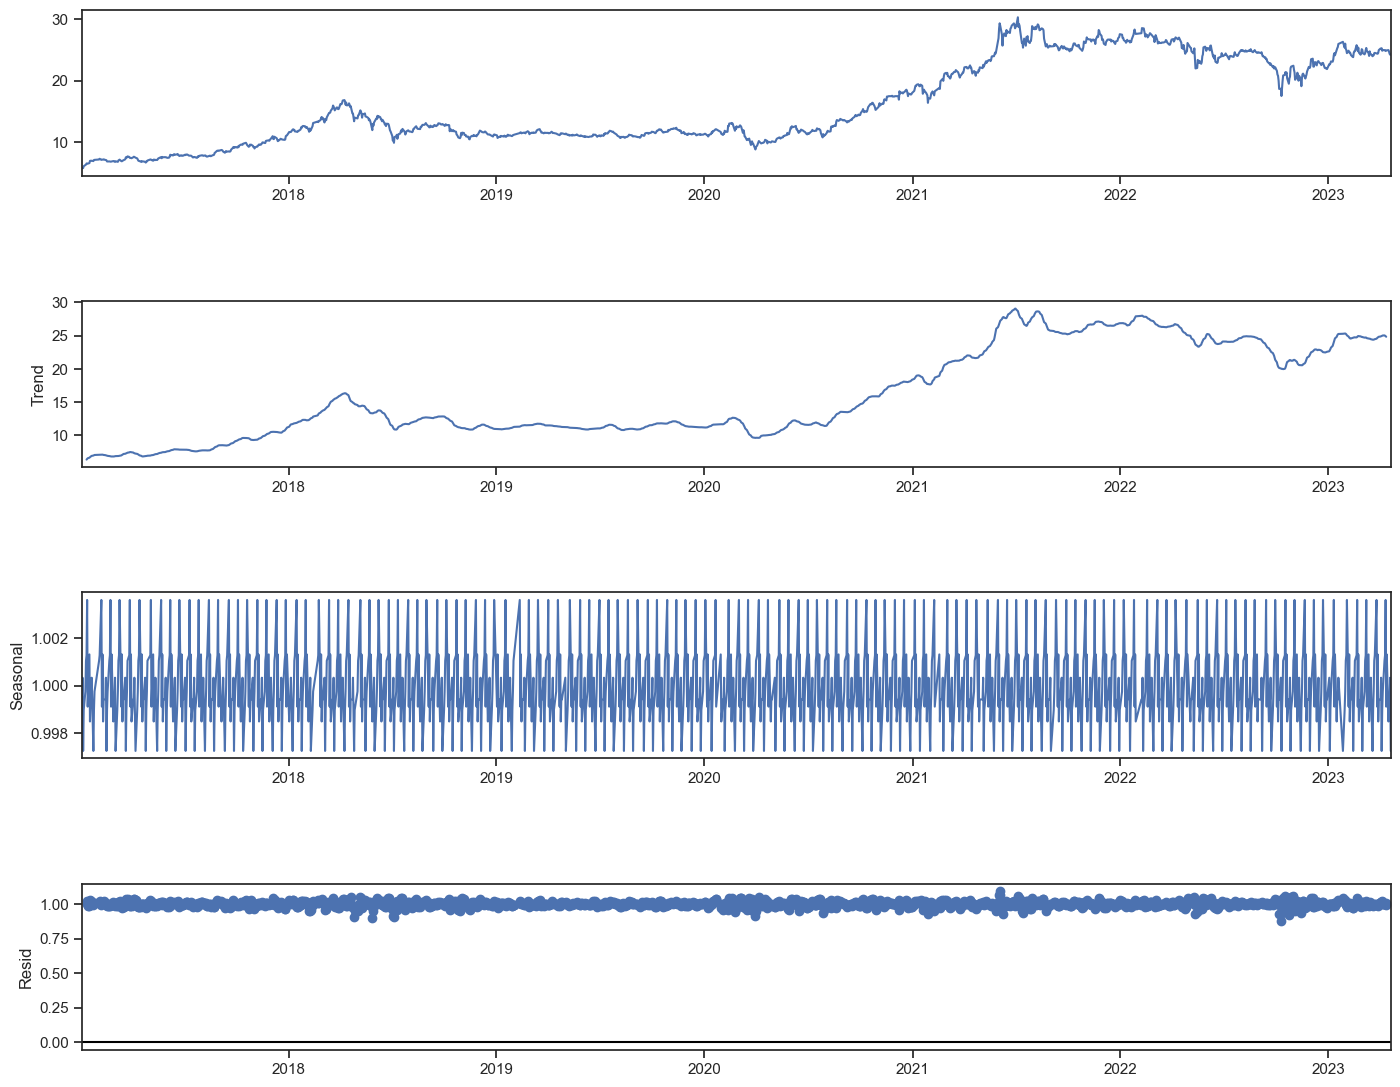

In [ ]:
result = seasonal_decompose(acb_df, model='multiplicative', period=12)
fig = result.plot()
fig.set_size_inches(16, 12)

### Thực hiện huấn luyện và dự đoán tập dữ liệu theo mô hình ARIMA

In [ ]:
train, test = acb_df[acb_df.index < '2023-04-01'], acb_df[acb_df.index >= '2023-04-01']
print('train shape: ', train.shape)
print('test shape: ', test.shape)

train shape:  (1560, 1)
test shape:  (15, 1)


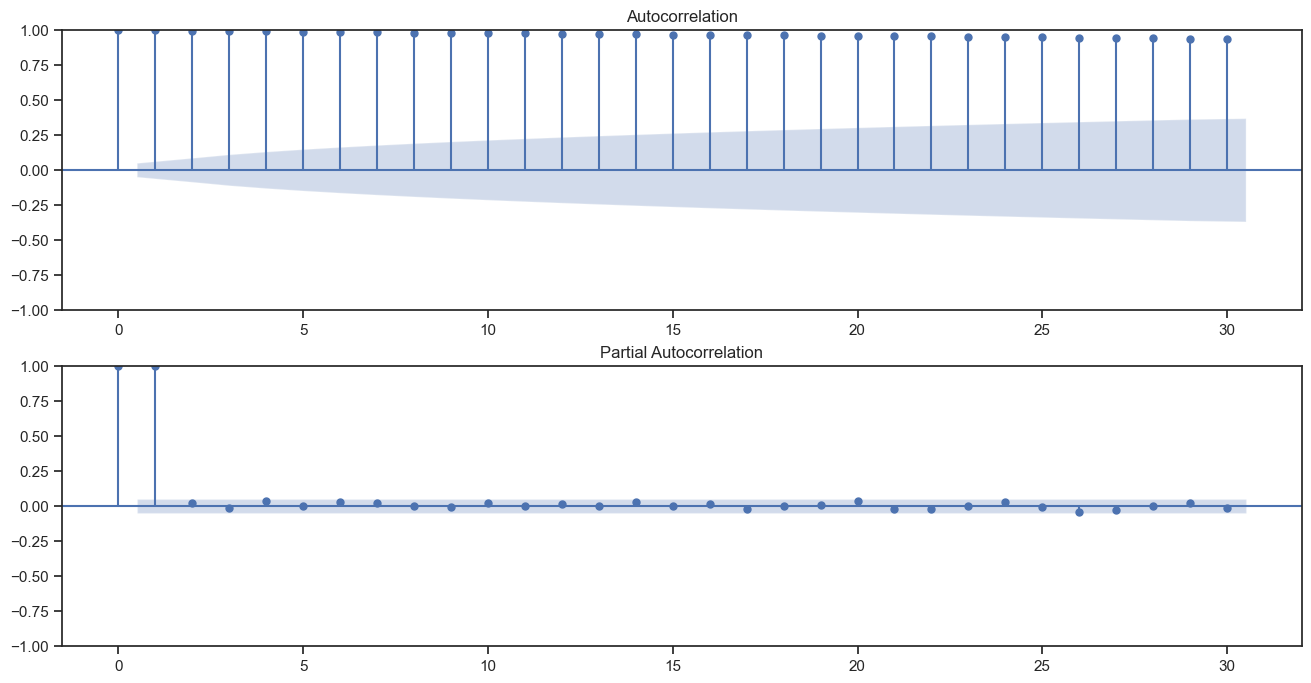

In [ ]:
#Vẽ biểu đồ ACF, PACF xác định các chỉ số p,d,q trong mô hình ARIMA
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8))

# Đồ thị ACF
plot_acf(train, lags=30, ax=ax1)

# Đồ thị PACF
plot_pacf(train, lags=30, ax=ax2, method='ywm')

plt.show()

#### Nhận xét
- Việc dự đoán dữ liệu dựa trên mô hình ARIMA (AutoRegressive Integrated Moving Average) là một phương pháp thống kê phổ biến được sử dụng để phân tích và dự đoán các chuỗi thời gian. Đây là một trong những phương pháp linh hoạt và mạnh mẽ nhất cho việc dự báo dữ liệu trong tương lai, đặc biệt là trong lĩnh vực tài chính và kinh tế.

Mô hình ARIMA kết hợp ba yếu tố chính:
1. **AR (AutoRegressive)**: Mô hình này xem xét sự phụ thuộc của biến phụ thuộc tại một thời điểm trước đó trong chuỗi thời gian. Nó giả định rằng giá trị hiện tại của biến phụ thuộc phụ thuộc vào giá trị của nó ở các thời điểm trước đó.
  
2. **I (Integrated)**: Bước này liên quan đến việc chuyển đổi dữ liệu để loại bỏ xu hướng (tích hợp). Điều này giúp làm cho dữ liệu trở nên ổn định hơn và giúp mô hình dự đoán tốt hơn.

3. **MA (Moving Average)**: Mô hình này xem xét sự phụ thuộc của biến phụ thuộc vào các giá trị ngẫu nhiên tại các thời điểm trước đó trong chuỗi thời gian.

Việc sử dụng mô hình ARIMA giúp dự báo xu hướng và biến động của dữ liệu trong tương lai dựa trên các mẫu quan sát được trong quá khứ. Tuy nhiên, cũng cần lưu ý rằng việc dự đoán dữ liệu luôn tồn tại một mức độ không chắc chắn, và kết quả dự báo có thể bị ảnh hưởng bởi nhiều yếu tố khác nhau như biến động thị trường, sự kiện không lường trước, hoặc sai số trong việc ước lượng mô hình.

In [ ]:

model_arima = auto_arima(train, start_p=0, start_q=0,
                           max_p=5, max_q=5, m=12,
                           start_P=0, seasonal=False,
                           d=0, D=0, trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)

print(model_arima.aic())

c:\Users\EV\AppData\Local\Programs\Python\Python37\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=13332.737, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=11235.545, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=1209.745, Time=0.33 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=1205.343, Time=0.59 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.44 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=1207.258, Time=0.80 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=1207.195, Time=0.79 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=1210.241, Time=0.57 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.51 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=1206.679, Time=0.96 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=1205.372, Time=1.20 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 6.574 seconds
1205.3434416263538


In [ ]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1560
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -598.672
Date:                Sun, 14 Apr 2024   AIC                           1205.343
Time:                        23:36:52   BIC                           1226.753
Sample:                             0   HQIC                          1213.304
                               - 1560                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0840      0.053      1.589      0.112      -0.020       0.188
ar.L2          0.9156      0.053     17.306      0.000       0.812       1.019
ma.L1          0.8883      0.060     14.853      0.0

c:\Users\EV\AppData\Local\Programs\Python\Python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:843: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  data=self.data,


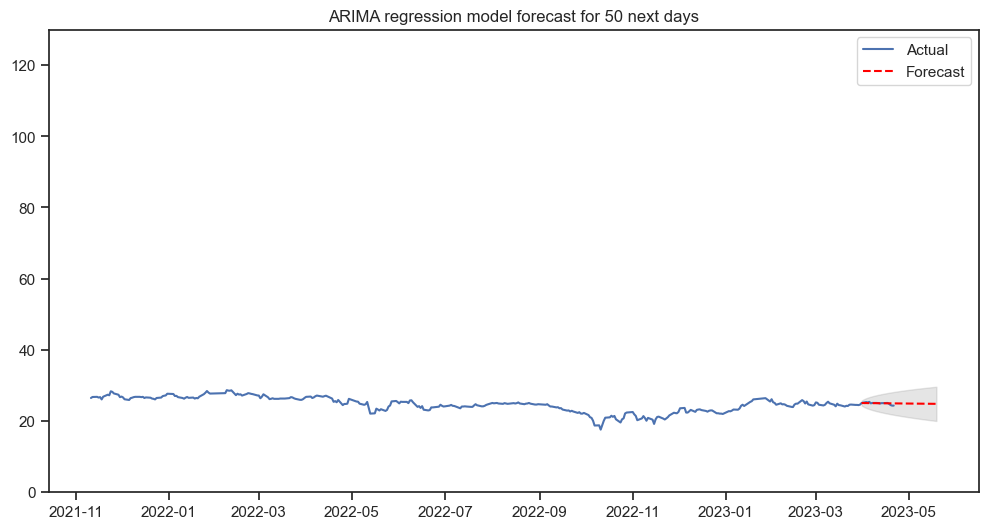

In [ ]:
n_pred_perious = 50
fitted, confint = model_arima.predict(n_periods=n_pred_perious, return_conf_int=True)
date = pd.date_range(train.index[-1], periods=n_pred_perious, freq='D')

fitted_seri = pd.Series(fitted.values, index=date)
lower = confint[:, 0]
upper = confint[:, 1]

plt.figure(figsize=(12, 6))
plt.plot(acb_df[-360:], label='Actual')
plt.plot(fitted_seri, color='red', linestyle='--', label = 'Forecast')
plt.fill_between(date,
                 lower,
                 upper,
                 color='grey', alpha=0.2)
plt.ylim((0, 130))
plt.legend()
plt.title('ARIMA regression model forecast for 50 next days')
plt.show()

In [ ]:
print(fitted_seri)

2023-03-31    24.967885
2023-04-01    24.988235
2023-04-02    24.960541
2023-04-03    24.976846
2023-04-04    24.952859
2023-04-05    24.965772
2023-04-06    24.944895
2023-04-07    24.954964
2023-04-08    24.936695
2023-04-09    24.944379
2023-04-10    24.928297
2023-04-11    24.933982
2023-04-12    24.919735
2023-04-13    24.923742
2023-04-14    24.911034
2023-04-15    24.913636
2023-04-16    24.902219
2023-04-17    24.903641
2023-04-18    24.893308
2023-04-19    24.893742
2023-04-20    24.884317
2023-04-21    24.883922
2023-04-22    24.875259
2023-04-23    24.874170
2023-04-24    24.866147
2023-04-25    24.864475
2023-04-26    24.856989
2023-04-27    24.854829
2023-04-28    24.847793
2023-04-29    24.845224
2023-04-30    24.838566
2023-05-01    24.835655
2023-05-02    24.829314
2023-05-03    24.826115
2023-05-04    24.820041
2023-05-05    24.816602
2023-05-06    24.810751
2023-05-07    24.807110
2023-05-08    24.801447
2023-05-09    24.797638
2023-05-10    24.792133
2023-05-11    24

In [ ]:
def _measure_metric(y, yhat):
    e = y-yhat
    mse=np.mean(e**2)
    rmse=np.sqrt(mse)
    mae=np.mean(np.abs(e))
    mape=np.mean(e/y)
    print('Mean Square Error: {}'.format(mse))
    print('Root Mean Square Error: {}'.format(rmse))
    print('Mean Absolute Error: {}'.format(mae))
    print('Mean Absolute Percentage Error: {}'.format(mape))
    return mse, rmse, mae, mape

mse, rmse, mae, mape=_measure_metric(test.values[0], fitted)

Mean Square Error: 0.15257007990165955
Root Mean Square Error: 0.3906022016088229
Mean Absolute Error: 0.3846644819020621
Mean Absolute Percentage Error: 0.01523423690701236


Việc sử dụng mô hình ARIMA mang lại nhiều lợi ích quan trọng trong phân tích và dự báo dữ liệu thời gian:

1. **Dự báo tương lai:** ARIMA cho phép dự đoán xu hướng và biến động của dữ liệu trong tương lai, giúp các nhà đầu tư, nhà kinh doanh và các quản lý dự báo các xu hướng và biến động tiềm ẩn, từ đó đưa ra quyết định chiến lược.

2. **Phân tích chuỗi thời gian:** ARIMA giúp phân tích các mẫu và cấu trúc trong chuỗi thời gian, từ đó hiểu rõ hơn về các yếu tố ảnh hưởng và các mối quan hệ giữa các biến.

3. **Đánh giá hiệu suất:** ARIMA cung cấp các công cụ để đánh giá hiệu suất của mô hình dự đoán thông qua các phương pháp đánh giá như kiểm tra dữ liệu ngoại lai và đánh giá sai số dự báo.

4. **Dự báo trong thời gian ngắn hạn và dài hạn:** ARIMA có thể được sử dụng để dự báo dữ liệu trong cả thời gian ngắn hạn và dài hạn, tùy thuộc vào cấu trúc của chuỗi thời gian và mục tiêu của phân tích.

5. **Ổn định và linh hoạt:** ARIMA là một phương pháp ổn định và linh hoạt, có thể được áp dụng cho nhiều loại chuỗi thời gian khác nhau và điều chỉnh để phù hợp với yêu cầu cụ thể của từng vấn đề.